In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.5


# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

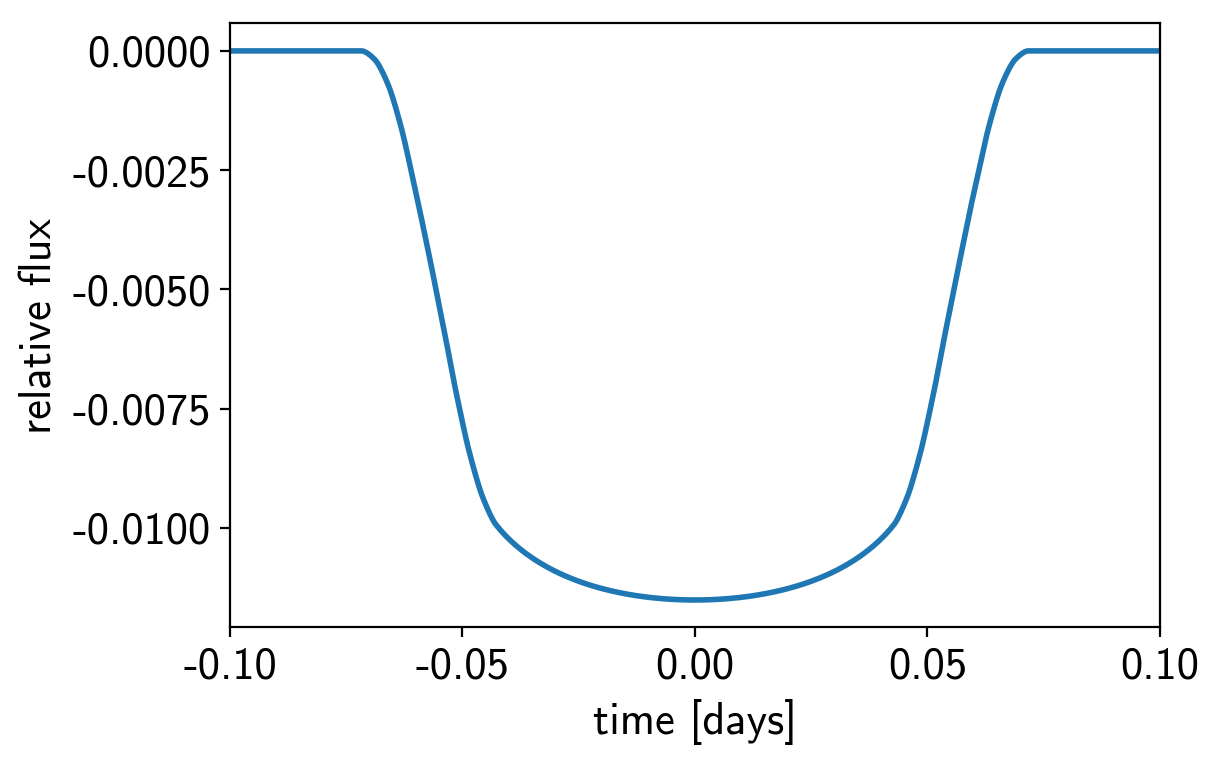

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = xo.StarryLightCurve(u).get_light_curve(
    orbit=orbit, r=0.1, t=t, texp=0.02).eval()
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009) and for the joint radius ratio and impact parameter distribution we'll use the parameterization from [Espinoza (2018)](https://arxiv.org/abs/1811.04859).
Both of these reparameterizations are implemented in *exoplanet* as custom *PyMC3* distributions (:class:`exoplanet.distributions.QuadLimbDark` and :class:`exoplanet.distributions.RadiusImpact` respectively).

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.01, max_radius=0.1,
        testval_r=np.array([0.04, 0.06]),
        testval_b=np.random.rand(2)
    )
    
    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curves = xo.StarryLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)
    
    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)
    
    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 24793.972586707856 -> 24799.526978939903


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

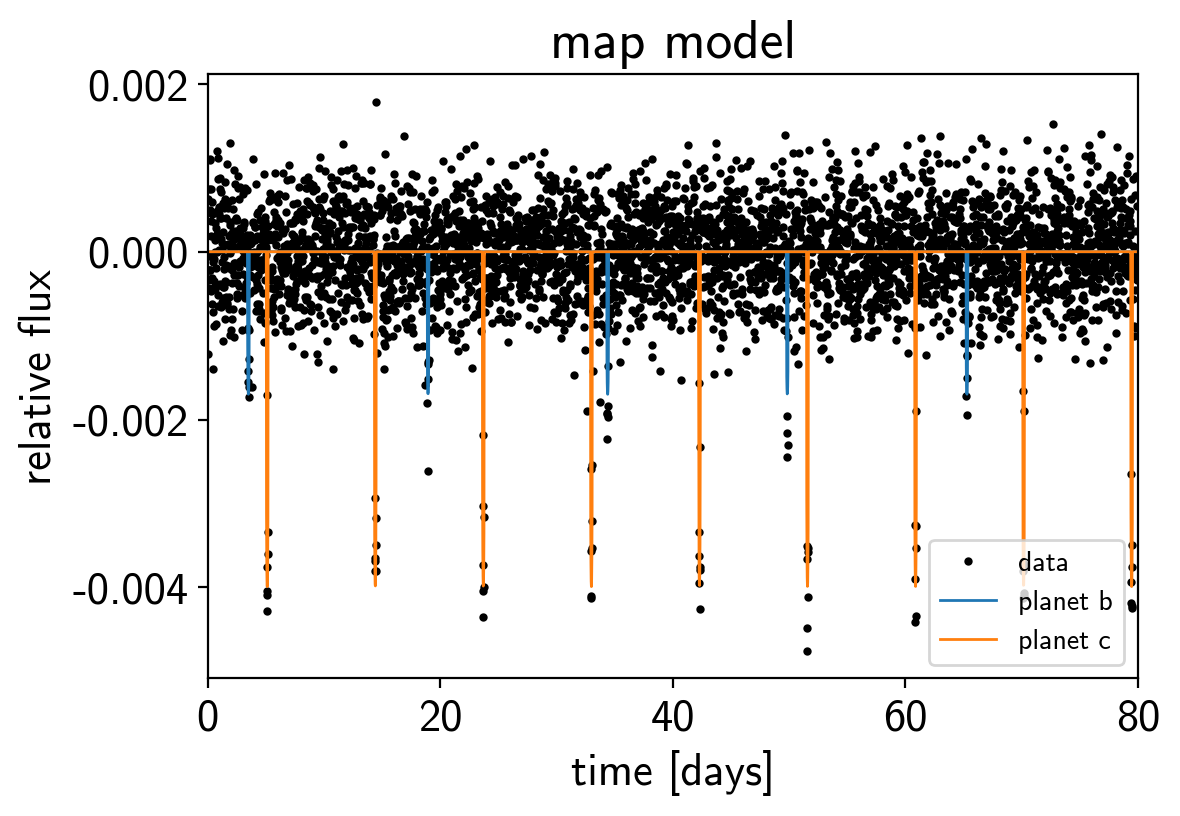

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1,
             label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use the :class:`exoplanet.PyMC3Sampler` to sample.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:00<00:04, 59.54draws/s]

Sampling 4 chains:   8%|▊         | 25/308 [00:00<00:09, 28.36draws/s]

Sampling 4 chains:   9%|▉         | 29/308 [00:00<00:13, 20.75draws/s]

Sampling 4 chains:  11%|█         | 33/308 [00:01<00:16, 17.18draws/s]

Sampling 4 chains:  12%|█▏        | 37/308 [00:01<00:17, 15.45draws/s]

Sampling 4 chains:  13%|█▎        | 41/308 [00:01<00:18, 14.51draws/s]

Sampling 4 chains:  15%|█▍        | 45/308 [00:02<00:19, 13.80draws/s]

Sampling 4 chains:  16%|█▌        | 49/308 [00:02<00:19, 13.46draws/s]

Sampling 4 chains:  17%|█▋        | 53/308 [00:02<00:19, 13.22draws/s]

Sampling 4 chains:  19%|█▉        | 58/308 [00:03<00:17, 13.91draws/s]

Sampling 4 chains:  20%|██        | 62/308 [00:03<00:18, 13.45draws/s]

Sampling 4 chains:  22%|██▏       | 67/308 [00:03<00:17, 14.07draws/s]

Sampling 4 chains:  23%|██▎       | 71/308 [00:04<00:17, 13.64draws/s]

Sampling 4 chains:  24%|██▍       | 75/308 [00:04<00:17, 13.35draws/s]

Sampling 4 chains:  26%|██▌       | 79/308 [00:04<00:17, 13.15draws/s]

Sampling 4 chains:  27%|██▋       | 82/308 [00:04<00:14, 15.73draws/s]

Sampling 4 chains:  27%|██▋       | 84/308 [00:05<00:20, 11.02draws/s]

Sampling 4 chains:  28%|██▊       | 87/308 [00:05<00:18, 11.66draws/s]

Sampling 4 chains:  29%|██▉       | 89/308 [00:05<00:16, 13.27draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:05<00:18, 11.72draws/s]

Sampling 4 chains:  30%|███       | 93/308 [00:05<00:16, 13.29draws/s]

Sampling 4 chains:  31%|███       | 95/308 [00:06<00:18, 11.79draws/s]

Sampling 4 chains:  31%|███▏      | 97/308 [00:06<00:15, 13.36draws/s]

Sampling 4 chains:  32%|███▏      | 100/308 [00:06<00:15, 13.60draws/s]

Sampling 4 chains:  33%|███▎      | 102/308 [00:06<00:13, 14.77draws/s]

Sampling 4 chains:  34%|███▍      | 104/308 [00:06<00:15, 12.75draws/s]

Sampling 4 chains:  34%|███▍      | 106/308 [00:06<00:14, 14.00draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:07<00:16, 12.40draws/s]

Sampling 4 chains:  36%|███▌      | 110/308 [00:07<00:14, 13.62draws/s]

Sampling 4 chains:  36%|███▋      | 112/308 [00:07<00:15, 12.26draws/s]

Sampling 4 chains:  37%|███▋      | 114/308 [00:07<00:14, 13.21draws/s]

Sampling 4 chains:  38%|███▊      | 116/308 [00:07<00:15, 12.15draws/s]

Sampling 4 chains:  38%|███▊      | 118/308 [00:07<00:14, 13.14draws/s]

Sampling 4 chains:  39%|███▉      | 120/308 [00:07<00:15, 12.20draws/s]

Sampling 4 chains:  40%|███▉      | 122/308 [00:08<00:14, 13.08draws/s]

Sampling 4 chains:  40%|████      | 124/308 [00:08<00:15, 12.15draws/s]

Sampling 4 chains:  41%|████      | 126/308 [00:08<00:13, 13.07draws/s]

Sampling 4 chains:  42%|████▏     | 128/308 [00:08<00:14, 12.22draws/s]

Sampling 4 chains:  42%|████▏     | 130/308 [00:08<00:13, 12.96draws/s]

Sampling 4 chains:  43%|████▎     | 132/308 [00:08<00:14, 12.23draws/s]

Sampling 4 chains:  44%|████▎     | 134/308 [00:09<00:13, 12.93draws/s]

Sampling 4 chains:  44%|████▍     | 136/308 [00:09<00:13, 12.32draws/s]

Sampling 4 chains:  45%|████▍     | 138/308 [00:09<00:13, 12.92draws/s]

Sampling 4 chains:  45%|████▌     | 140/308 [00:09<00:13, 12.38draws/s]

Sampling 4 chains:  46%|████▌     | 142/308 [00:09<00:12, 12.89draws/s]

Sampling 4 chains:  47%|████▋     | 144/308 [00:09<00:13, 12.42draws/s]

Sampling 4 chains:  48%|████▊     | 147/308 [00:09<00:11, 14.16draws/s]

Sampling 4 chains:  48%|████▊     | 149/308 [00:10<00:12, 13.10draws/s]

Sampling 4 chains:  49%|████▉     | 151/308 [00:10<00:11, 13.48draws/s]

Sampling 4 chains:  50%|████▉     | 153/308 [00:10<00:12, 12.77draws/s]

Sampling 4 chains:  50%|█████     | 155/308 [00:10<00:11, 13.14draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [00:10<00:12, 12.56draws/s]

Sampling 4 chains:  52%|█████▏    | 159/308 [00:10<00:11, 12.63draws/s]

Sampling 4 chains:  52%|█████▏    | 161/308 [00:11<00:11, 12.63draws/s]

Sampling 4 chains:  53%|█████▎    | 163/308 [00:11<00:11, 12.60draws/s]

Sampling 4 chains:  54%|█████▎    | 165/308 [00:11<00:11, 12.70draws/s]

Sampling 4 chains:  54%|█████▍    | 167/308 [00:11<00:11, 12.55draws/s]

Sampling 4 chains:  55%|█████▍    | 169/308 [00:11<00:10, 12.76draws/s]

Sampling 4 chains:  56%|█████▌    | 171/308 [00:11<00:10, 12.51draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [00:12<00:10, 12.71draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [00:12<00:10, 12.48draws/s]

Sampling 4 chains:  57%|█████▋    | 177/308 [00:12<00:10, 12.79draws/s]

Sampling 4 chains:  58%|█████▊    | 179/308 [00:12<00:10, 12.45draws/s]

Sampling 4 chains:  59%|█████▉    | 181/308 [00:12<00:09, 12.81draws/s]

Sampling 4 chains:  59%|█████▉    | 183/308 [00:12<00:10, 12.34draws/s]

Sampling 4 chains:  60%|██████    | 185/308 [00:13<00:09, 12.90draws/s]

Sampling 4 chains:  61%|██████    | 187/308 [00:13<00:09, 12.33draws/s]

Sampling 4 chains:  61%|██████▏   | 189/308 [00:13<00:09, 12.99draws/s]

Sampling 4 chains:  62%|██████▏   | 191/308 [00:13<00:09, 12.29draws/s]

Sampling 4 chains:  63%|██████▎   | 193/308 [00:13<00:08, 13.07draws/s]

Sampling 4 chains:  63%|██████▎   | 195/308 [00:13<00:09, 12.25draws/s]

Sampling 4 chains:  64%|██████▍   | 197/308 [00:13<00:08, 13.13draws/s]

Sampling 4 chains:  65%|██████▍   | 199/308 [00:14<00:08, 12.21draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [00:14<00:08, 13.18draws/s]

Sampling 4 chains:  66%|██████▌   | 203/308 [00:14<00:08, 12.17draws/s]

Sampling 4 chains:  67%|██████▋   | 205/308 [00:14<00:07, 13.22draws/s]

Sampling 4 chains:  67%|██████▋   | 207/308 [00:14<00:08, 12.14draws/s]

Sampling 4 chains:  68%|██████▊   | 209/308 [00:14<00:07, 13.28draws/s]

Sampling 4 chains:  69%|██████▊   | 211/308 [00:15<00:08, 12.08draws/s]

Sampling 4 chains:  69%|██████▉   | 213/308 [00:15<00:07, 13.34draws/s]

Sampling 4 chains:  70%|██████▉   | 215/308 [00:15<00:07, 12.03draws/s]

Sampling 4 chains:  70%|███████   | 217/308 [00:15<00:06, 13.26draws/s]

Sampling 4 chains:  71%|███████   | 219/308 [00:15<00:07, 11.67draws/s]

Sampling 4 chains:  72%|███████▏  | 222/308 [00:15<00:06, 12.67draws/s]

Sampling 4 chains:  73%|███████▎  | 224/308 [00:16<00:06, 13.29draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [00:16<00:06, 12.53draws/s]

Sampling 4 chains:  74%|███████▍  | 228/308 [00:16<00:06, 13.09draws/s]

Sampling 4 chains:  75%|███████▍  | 230/308 [00:16<00:06, 12.50draws/s]

Sampling 4 chains:  75%|███████▌  | 232/308 [00:16<00:05, 12.94draws/s]

Sampling 4 chains:  76%|███████▌  | 234/308 [00:16<00:05, 12.51draws/s]

Sampling 4 chains:  77%|███████▋  | 236/308 [00:17<00:05, 12.86draws/s]

Sampling 4 chains:  77%|███████▋  | 238/308 [00:17<00:05, 12.55draws/s]

Sampling 4 chains:  78%|███████▊  | 240/308 [00:17<00:05, 12.79draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:17<00:05, 12.60draws/s]

Sampling 4 chains:  79%|███████▉  | 244/308 [00:17<00:05, 12.74draws/s]

Sampling 4 chains:  80%|███████▉  | 246/308 [00:17<00:04, 12.63draws/s]

Sampling 4 chains:  81%|████████  | 248/308 [00:17<00:04, 12.68draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:18<00:04, 12.68draws/s]

Sampling 4 chains:  82%|████████▏ | 252/308 [00:18<00:04, 12.56draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [00:18<00:04, 12.38draws/s]

Sampling 4 chains:  83%|████████▎ | 256/308 [00:18<00:04, 12.64draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [00:18<00:04, 12.48draws/s]

Sampling 4 chains:  84%|████████▍ | 260/308 [00:18<00:03, 12.66draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [00:19<00:03, 12.56draws/s]

Sampling 4 chains:  86%|████████▌ | 264/308 [00:19<00:03, 12.66draws/s]

Sampling 4 chains:  86%|████████▋ | 266/308 [00:19<00:03, 12.61draws/s]

Sampling 4 chains:  87%|████████▋ | 268/308 [00:19<00:03, 12.64draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [00:19<00:02, 12.67draws/s]

Sampling 4 chains:  88%|████████▊ | 272/308 [00:19<00:02, 12.61draws/s]

Sampling 4 chains:  89%|████████▉ | 274/308 [00:20<00:02, 12.74draws/s]

Sampling 4 chains:  90%|████████▉ | 276/308 [00:20<00:02, 12.56draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [00:20<00:02, 12.81draws/s]

Sampling 4 chains:  91%|█████████ | 280/308 [00:20<00:02, 12.51draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [00:20<00:02, 12.86draws/s]

Sampling 4 chains:  92%|█████████▏| 284/308 [00:20<00:01, 12.46draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:20<00:01, 12.92draws/s]

Sampling 4 chains:  94%|█████████▎| 288/308 [00:21<00:01, 12.39draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:21<00:01, 12.98draws/s]

Sampling 4 chains:  95%|█████████▍| 292/308 [00:21<00:01, 12.35draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:21<00:01, 13.02draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [00:21<00:00, 12.29draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:21<00:00, 13.08draws/s]

Sampling 4 chains:  97%|█████████▋| 300/308 [00:22<00:00, 11.99draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:22<00:00,  9.48draws/s]

Sampling 4 chains:  99%|█████████▊| 304/308 [00:22<00:00,  8.22draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:23<00:00,  4.67draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:23<00:00,  4.66draws/s]

Sampling 4 chains: 100%|█████████▉| 307/308 [00:23<00:00,  3.90draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:24<00:00,  3.83draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:06, 57.01draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:13, 27.76draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:01<00:18, 20.22draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:01<00:20, 18.53draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:01<00:22, 16.14draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:01<00:22, 16.03draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:02<00:24, 14.61draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:02<00:25, 13.95draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:02<00:23, 15.07draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:03<00:24, 14.24draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:03<00:23, 14.66draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:03<00:22, 14.91draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:04<00:21, 15.15draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:04<00:20, 16.11draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:04<00:21, 14.86draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:05<00:20, 15.12draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:05<00:20, 15.25draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:05<00:17, 17.77draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:05<00:25, 12.15draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:06<00:25, 12.13draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:06<00:20, 14.72draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:06<00:27, 10.91draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:06<00:26, 11.31draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:06<00:21, 13.76draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:07<00:27, 10.66draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:07<00:25, 11.12draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:07<00:20, 14.07draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:07<00:21, 12.79draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:08<00:21, 12.69draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:08<00:18, 14.96draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:08<00:20, 13.02draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:08<00:19, 13.98draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:08<00:18, 14.30draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:08<00:17, 14.84draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:08<00:17, 14.78draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:09<00:17, 15.24draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:09<00:19, 13.27draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:09<00:18, 14.02draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [00:09<00:17, 14.42draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:09<00:17, 14.70draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:09<00:18, 13.19draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [00:10<00:18, 13.77draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:10<00:19, 12.67draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:10<00:18, 13.33draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:10<00:19, 12.35draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:10<00:18, 13.16draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [00:10<00:19, 12.27draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:11<00:18, 13.04draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:11<00:19, 12.20draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:11<00:17, 12.91draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:11<00:18, 12.24draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:11<00:16, 14.14draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [00:11<00:17, 13.03draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:11<00:16, 13.47draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [00:12<00:17, 12.66draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:12<00:16, 13.14draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:12<00:17, 12.50draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:12<00:16, 12.97draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:12<00:14, 14.66draws/s]

Sampling 4 chains:  49%|████▉     | 199/408 [00:12<00:14, 14.69draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:13<00:15, 13.30draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:13<00:14, 13.85draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:13<00:14, 14.43draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [00:13<00:13, 14.50draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:13<00:14, 13.24draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:13<00:14, 13.72draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:14<00:15, 12.71draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:14<00:14, 13.40draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:14<00:15, 12.44draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:14<00:14, 13.27draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:14<00:14, 12.41draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:14<00:13, 13.19draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:15<00:13, 13.91draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:15<00:12, 14.37draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:15<00:13, 13.05draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [00:15<00:12, 13.65draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:15<00:13, 12.73draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [00:15<00:12, 13.32draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:15<00:13, 12.59draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:16<00:12, 13.05draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [00:16<00:13, 12.56draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [00:16<00:11, 14.28draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:16<00:11, 13.41draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:16<00:11, 13.49draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:16<00:12, 12.99draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:17<00:11, 13.13draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:17<00:11, 12.81draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:17<00:11, 12.94draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:17<00:11, 12.74draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:17<00:10, 14.22draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:17<00:10, 13.63draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:18<00:10, 13.43draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:18<00:10, 13.15draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:18<00:09, 14.49draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:18<00:10, 13.03draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:18<00:09, 13.77draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:18<00:10, 12.64draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:18<00:09, 13.39draws/s]

Sampling 4 chains:  69%|██████▉   | 282/408 [00:19<00:10, 12.49draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:19<00:09, 13.23draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:19<00:09, 12.38draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:19<00:08, 14.40draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:19<00:08, 13.09draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:19<00:07, 15.03draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:20<00:07, 15.16draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:20<00:07, 15.25draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:20<00:06, 15.53draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:20<00:06, 15.47draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:20<00:07, 13.73draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:20<00:07, 14.09draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:21<00:07, 12.95draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:21<00:06, 14.86draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:21<00:07, 13.23draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:21<00:06, 13.95draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:21<00:07, 12.63draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:21<00:06, 13.55draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:22<00:06, 12.42draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:22<00:06, 13.38draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:22<00:06, 12.34draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:22<00:05, 13.28draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:22<00:06, 12.31draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:22<00:05, 13.22draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:22<00:05, 13.91draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [00:23<00:04, 14.32draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:23<00:05, 13.05draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:23<00:04, 13.66draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:23<00:05, 12.68draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:23<00:04, 13.34draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:23<00:04, 12.52draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:24<00:04, 13.14draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:24<00:04, 12.44draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:24<00:04, 13.06draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [00:24<00:03, 14.92draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:24<00:03, 14.65draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:24<00:03, 13.59draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:24<00:03, 13.70draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:25<00:03, 13.02draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [00:25<00:03, 13.28draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:25<00:02, 12.77draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:25<00:02, 13.07draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:25<00:02, 12.67draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:25<00:02, 12.95draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:26<00:02, 12.64draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:26<00:02, 12.84draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:26<00:01, 14.12draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:26<00:01, 13.52draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:26<00:01, 13.44draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:26<00:01, 12.97draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:27<00:01, 13.19draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:27<00:01, 12.73draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:27<00:00, 13.97draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:27<00:00, 10.28draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:28<00:01,  6.26draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:28<00:00,  6.67draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:28<00:00,  7.25draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:28<00:00,  6.31draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:28<00:00,  6.74draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:29<00:00,  5.04draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:29<00:00,  4.29draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:30<00:00,  1.84draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<01:38,  8.16draws/s]

Sampling 4 chains:   1%|          | 5/808 [00:00<01:20, 10.03draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:00<01:01, 12.86draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<01:01, 12.95draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:53, 14.87draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:45, 17.31draws/s]

Sampling 4 chains:   3%|▎         | 24/808 [00:01<00:51, 15.32draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:01<00:50, 15.60draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:01<00:49, 15.83draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:01<00:57, 13.52draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:01<00:57, 13.44draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:01<00:50, 15.17draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:02<00:57, 13.34draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:02<00:51, 14.91draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:02<01:01, 12.42draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:02<00:56, 13.58draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:02<01:02, 12.18draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:02<00:59, 12.77draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:03<01:01, 12.21draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:03<01:01, 12.31draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:03<00:57, 13.18draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:03<00:55, 13.63draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:03<00:48, 15.44draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:03<00:47, 15.74draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:04<00:50, 14.61draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:04<00:52, 13.92draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:04<00:54, 13.37draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:05<00:47, 15.19draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:05<00:50, 14.42draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:05<00:46, 15.44draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:05<00:49, 14.55draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:05<00:44, 16.11draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:05<00:41, 17.39draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:06<00:37, 19.19draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:06<00:31, 22.69draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:06<00:37, 18.90draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:06<00:34, 20.44draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:06<00:38, 17.90draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:06<00:39, 17.63draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:06<00:38, 17.89draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:07<00:49, 14.10draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:07<00:45, 15.28draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:07<00:54, 12.72draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:07<00:44, 15.44draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:07<00:44, 15.36draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:07<00:45, 14.92draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:08<00:53, 12.74draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:08<00:45, 14.70draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:08<00:41, 16.00draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:08<00:40, 16.52draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:08<00:39, 16.69draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:09<00:36, 18.15draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:09<00:41, 15.92draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:09<00:33, 19.23draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:09<00:31, 20.26draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:09<00:34, 18.40draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:09<00:32, 20.00draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:10<00:38, 16.61draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:10<00:37, 17.04draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:10<00:37, 16.91draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:10<00:31, 20.14draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:10<00:28, 21.64draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:10<00:30, 20.17draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:10<00:29, 20.97draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:11<00:28, 21.97draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:11<00:26, 22.90draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:11<00:27, 22.44draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:11<00:31, 19.52draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:11<00:28, 21.31draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:11<00:34, 17.15draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:12<00:33, 18.04draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:12<00:38, 15.39draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:12<00:39, 14.90draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:12<00:40, 14.63draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:12<00:35, 16.38draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:12<00:37, 15.58draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:13<00:41, 13.97draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:13<00:41, 13.90draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:13<00:34, 16.48draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:13<00:35, 16.29draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:13<00:32, 17.69draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:13<00:27, 20.59draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:14<00:34, 16.58draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:14<00:37, 15.08draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:14<00:39, 14.17draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:14<00:40, 13.81draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:14<00:37, 14.83draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:14<00:39, 14.03draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:15<00:31, 17.15draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:15<00:28, 18.80draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:15<00:24, 21.74draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:15<00:32, 16.51draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:15<00:33, 16.02draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:16<00:37, 14.08draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:16<00:33, 15.90draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:16<00:36, 14.24draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:16<00:31, 16.83draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:16<00:27, 18.84draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:16<00:25, 20.60draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:16<00:24, 20.99draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:16<00:23, 22.01draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:17<00:27, 18.45draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:17<00:23, 21.04draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:17<00:28, 17.70draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:17<00:27, 18.02draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:17<00:29, 16.91draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:18<00:30, 16.37draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:18<00:34, 14.06draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:18<00:30, 15.93draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:18<00:37, 13.07draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:18<00:33, 14.50draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:18<00:30, 15.61draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:18<00:30, 15.66draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:19<00:35, 13.61draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:19<00:34, 13.78draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:19<00:33, 13.95draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:19<00:35, 13.26draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:19<00:29, 15.79draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:19<00:28, 16.05draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:20<00:29, 15.84draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:20<00:27, 16.94draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:20<00:23, 19.37draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:20<00:27, 16.49draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:20<00:28, 15.52draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:21<00:27, 15.99draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:21<00:28, 15.30draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:21<00:28, 15.59draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:21<00:26, 16.33draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:21<00:27, 15.60draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:21<00:26, 16.27draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:21<00:23, 17.96draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:22<00:21, 19.86draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:22<00:23, 17.84draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:22<00:21, 19.31draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:22<00:25, 16.42draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:22<00:31, 13.08draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:23<00:26, 15.32draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:23<00:30, 13.39draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:23<00:27, 14.86draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:23<00:26, 15.15draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:23<00:23, 16.88draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:23<00:32, 12.24draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:24<00:26, 14.68draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:24<00:26, 14.58draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:24<00:24, 15.77draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:24<00:26, 14.48draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:24<00:25, 15.23draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:24<00:25, 15.15draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:25<00:24, 15.24draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:25<00:24, 15.19draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:25<00:25, 14.92draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:25<00:27, 13.53draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:25<00:26, 14.26draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:25<00:23, 15.38draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:26<00:28, 12.91draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:26<00:24, 14.75draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [00:26<00:27, 13.21draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:26<00:30, 11.83draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [00:26<00:29, 12.03draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [00:27<00:23, 14.74draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:27<00:22, 15.09draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:27<00:22, 15.10draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [00:27<00:21, 15.67draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:27<00:21, 15.48draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:27<00:21, 15.93draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:28<00:19, 17.16draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:28<00:17, 19.00draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:28<00:19, 17.16draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:28<00:14, 21.81draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [00:28<00:17, 17.71draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [00:29<00:19, 15.92draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [00:29<00:16, 18.65draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:29<00:16, 18.41draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [00:29<00:18, 16.66draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:29<00:17, 16.78draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [00:29<00:16, 17.90draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [00:30<00:22, 13.25draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:30<00:22, 13.07draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [00:30<00:17, 16.55draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:30<00:18, 15.50draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [00:31<00:15, 17.56draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:31<00:13, 19.86draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [00:31<00:15, 17.35draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:31<00:13, 19.59draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:31<00:15, 17.12draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [00:31<00:13, 19.40draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:31<00:13, 19.51draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:32<00:15, 16.60draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:32<00:12, 20.10draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:32<00:14, 17.67draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:32<00:14, 17.45draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:32<00:15, 15.59draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:33<00:13, 17.31draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:33<00:12, 18.67draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:33<00:15, 15.53draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:33<00:12, 19.13draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:33<00:10, 20.74draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [00:33<00:10, 22.31draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:33<00:10, 21.89draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:34<00:10, 21.04draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:34<00:09, 22.80draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:34<00:08, 24.02draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:34<00:08, 24.90draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:34<00:10, 20.01draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [00:34<00:10, 18.86draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:35<00:10, 18.65draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:35<00:09, 20.41draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [00:35<00:10, 18.38draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [00:35<00:09, 20.06draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:35<00:10, 17.35draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:35<00:11, 15.57draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [00:36<00:10, 17.32draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:36<00:11, 15.76draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [00:36<00:09, 17.79draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [00:36<00:12, 13.78draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:36<00:11, 15.45draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:36<00:13, 12.36draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:37<00:13, 12.12draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:37<00:11, 13.90draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:37<00:13, 12.33draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:37<00:11, 13.99draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [00:37<00:10, 14.38draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:38<00:09, 15.44draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:38<00:09, 16.35draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:38<00:10, 14.03draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:38<00:10, 14.48draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:38<00:09, 15.08draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:38<00:07, 17.63draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:38<00:10, 13.87draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [00:39<00:07, 17.23draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:39<00:08, 15.09draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:39<00:08, 15.31draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:39<00:07, 17.36draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:39<00:07, 16.50draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:39<00:06, 18.60draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:40<00:05, 19.90draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [00:40<00:06, 18.45draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [00:40<00:06, 16.95draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [00:40<00:08, 13.00draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [00:40<00:07, 13.85draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [00:41<00:07, 14.68draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [00:41<00:05, 16.74draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:41<00:05, 16.18draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [00:41<00:05, 16.37draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:41<00:05, 17.63draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:41<00:05, 15.32draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:41<00:05, 14.72draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [00:42<00:04, 17.03draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:42<00:05, 14.93draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:42<00:05, 15.53draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:42<00:05, 14.81draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:42<00:04, 18.03draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:42<00:04, 16.48draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:43<00:04, 15.96draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:43<00:04, 14.01draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:43<00:04, 14.32draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [00:43<00:04, 13.04draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:43<00:04, 13.52draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:43<00:04, 14.17draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [00:44<00:03, 15.21draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:44<00:03, 16.93draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:44<00:02, 17.63draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:44<00:03, 13.30draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:44<00:03, 12.16draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:44<00:03, 13.27draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:45<00:03, 11.75draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:45<00:03, 11.99draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:45<00:03, 10.39draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:45<00:02, 12.02draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:45<00:02, 11.86draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:45<00:02, 13.30draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:46<00:02, 13.87draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [00:46<00:01, 13.55draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:46<00:01, 13.17draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:46<00:01, 12.74draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:46<00:01, 12.57draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:46<00:01, 12.73draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:47<00:01,  9.76draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:47<00:01,  8.40draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:47<00:01,  8.48draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:47<00:00,  9.90draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:48<00:00, 10.92draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:48<00:00, 10.41draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:48<00:00,  9.17draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:49<00:00,  4.53draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:49<00:00,  4.26draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:00<00:12, 126.69draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:00<00:12, 130.23draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:00<00:10, 152.49draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:00<00:09, 156.14draws/s]

Sampling 4 chains:   6%|▌         | 92/1608 [00:00<00:09, 166.68draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:00<00:08, 180.53draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:00<00:08, 180.16draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:00<00:08, 179.35draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:00<00:07, 186.49draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:01<00:08, 173.98draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [00:01<00:07, 187.56draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:01<00:07, 189.42draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:01<00:07, 191.38draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:01<00:06, 204.88draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [00:01<00:06, 201.64draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [00:01<00:06, 200.05draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:01<00:06, 198.51draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:01<00:06, 198.62draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:01<00:06, 200.39draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [00:02<00:05, 209.42draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:02<00:05, 208.43draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:02<00:05, 206.64draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [00:02<00:05, 212.57draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [00:02<00:05, 213.32draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [00:02<00:05, 209.35draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [00:02<00:05, 199.15draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [00:02<00:05, 200.13draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [00:02<00:04, 215.62draws/s]

Sampling 4 chains:  38%|███▊      | 611/1608 [00:03<00:04, 212.03draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [00:03<00:04, 210.74draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [00:03<00:04, 206.97draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [00:03<00:04, 204.84draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [00:03<00:04, 210.54draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [00:03<00:04, 214.19draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [00:03<00:04, 214.24draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [00:03<00:04, 205.56draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [00:03<00:03, 207.94draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [00:04<00:04, 197.97draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [00:04<00:03, 195.89draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [00:04<00:03, 216.86draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [00:04<00:03, 222.70draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [00:04<00:03, 215.39draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [00:04<00:03, 222.98draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [00:04<00:02, 221.12draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [00:04<00:02, 214.76draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [00:04<00:02, 220.09draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [00:04<00:02, 211.64draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [00:05<00:02, 202.47draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [00:05<00:02, 211.83draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [00:05<00:02, 212.65draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [00:05<00:02, 205.13draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [00:05<00:02, 216.61draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [00:05<00:02, 212.55draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [00:05<00:01, 214.66draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [00:05<00:01, 221.64draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [00:05<00:01, 215.02draws/s]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [00:06<00:01, 214.94draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [00:06<00:01, 211.72draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [00:06<00:01, 226.13draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [00:06<00:01, 217.06draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [00:06<00:01, 214.63draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [00:06<00:01, 211.43draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [00:06<00:01, 208.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [00:06<00:00, 219.01draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [00:06<00:00, 224.25draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [00:07<00:00, 227.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [00:07<00:00, 211.96draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [00:07<00:00, 199.22draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [00:07<00:00, 181.82draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [00:07<00:00, 183.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [00:07<00:00, 141.32draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [00:08<00:00, 83.01draws/s] 

Sampling 4 chains:  99%|█████████▉| 1598/1608 [00:08<00:00, 70.87draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:08<00:00, 188.10draws/s]

Sampling 4 chains:   0%|          | 0/6908 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 14/6908 [00:00<00:53, 128.55draws/s]

Sampling 4 chains:   0%|          | 25/6908 [00:00<00:56, 121.59draws/s]

Sampling 4 chains:   1%|          | 41/6908 [00:00<00:52, 130.93draws/s]

Sampling 4 chains:   1%|          | 57/6908 [00:00<00:49, 137.87draws/s]

Sampling 4 chains:   1%|          | 75/6908 [00:00<00:47, 142.63draws/s]

Sampling 4 chains:   1%|▏         | 91/6908 [00:00<00:46, 147.27draws/s]

Sampling 4 chains:   2%|▏         | 112/6908 [00:00<00:42, 161.18draws/s]

Sampling 4 chains:   2%|▏         | 133/6908 [00:00<00:39, 171.79draws/s]

Sampling 4 chains:   2%|▏         | 151/6908 [00:00<00:44, 151.10draws/s]

Sampling 4 chains:   2%|▏         | 167/6908 [00:01<00:45, 146.60draws/s]

Sampling 4 chains:   3%|▎         | 184/6908 [00:01<00:44, 152.00draws/s]

Sampling 4 chains:   3%|▎         | 200/6908 [00:01<00:45, 146.57draws/s]

Sampling 4 chains:   3%|▎         | 218/6908 [00:01<00:43, 154.92draws/s]

Sampling 4 chains:   3%|▎         | 236/6908 [00:01<00:42, 155.49draws/s]

Sampling 4 chains:   4%|▎         | 253/6908 [00:01<00:41, 159.51draws/s]

Sampling 4 chains:   4%|▍         | 270/6908 [00:01<00:42, 155.59draws/s]

Sampling 4 chains:   4%|▍         | 286/6908 [00:01<00:42, 155.85draws/s]

Sampling 4 chains:   4%|▍         | 302/6908 [00:01<00:42, 155.80draws/s]

Sampling 4 chains:   5%|▍         | 321/6908 [00:02<00:40, 163.83draws/s]

Sampling 4 chains:   5%|▍         | 340/6908 [00:02<00:39, 166.47draws/s]

Sampling 4 chains:   5%|▌         | 357/6908 [00:02<00:40, 161.79draws/s]

Sampling 4 chains:   5%|▌         | 378/6908 [00:02<00:38, 169.39draws/s]

Sampling 4 chains:   6%|▌         | 396/6908 [00:02<00:38, 169.59draws/s]

Sampling 4 chains:   6%|▌         | 416/6908 [00:02<00:37, 175.07draws/s]

Sampling 4 chains:   6%|▋         | 434/6908 [00:02<00:39, 163.60draws/s]

Sampling 4 chains:   7%|▋         | 453/6908 [00:02<00:38, 166.55draws/s]

Sampling 4 chains:   7%|▋         | 471/6908 [00:02<00:37, 169.45draws/s]

Sampling 4 chains:   7%|▋         | 489/6908 [00:03<00:37, 172.03draws/s]

Sampling 4 chains:   7%|▋         | 508/6908 [00:03<00:36, 175.05draws/s]

Sampling 4 chains:   8%|▊         | 526/6908 [00:03<00:36, 175.45draws/s]

Sampling 4 chains:   8%|▊         | 546/6908 [00:03<00:35, 181.62draws/s]

Sampling 4 chains:   8%|▊         | 568/6908 [00:03<00:33, 191.44draws/s]

Sampling 4 chains:   9%|▊         | 588/6908 [00:03<00:32, 192.32draws/s]

Sampling 4 chains:   9%|▉         | 609/6908 [00:03<00:32, 195.61draws/s]

Sampling 4 chains:   9%|▉         | 630/6908 [00:03<00:31, 197.31draws/s]

Sampling 4 chains:   9%|▉         | 650/6908 [00:03<00:33, 189.13draws/s]

Sampling 4 chains:  10%|▉         | 670/6908 [00:03<00:33, 188.52draws/s]

Sampling 4 chains:  10%|▉         | 689/6908 [00:04<00:34, 180.72draws/s]

Sampling 4 chains:  10%|█         | 708/6908 [00:04<00:34, 181.35draws/s]

Sampling 4 chains:  11%|█         | 728/6908 [00:04<00:33, 185.86draws/s]

Sampling 4 chains:  11%|█         | 750/6908 [00:04<00:31, 194.29draws/s]

Sampling 4 chains:  11%|█         | 770/6908 [00:04<00:32, 190.25draws/s]

Sampling 4 chains:  11%|█▏        | 790/6908 [00:04<00:32, 190.19draws/s]

Sampling 4 chains:  12%|█▏        | 812/6908 [00:04<00:30, 196.88draws/s]

Sampling 4 chains:  12%|█▏        | 833/6908 [00:04<00:30, 200.16draws/s]

Sampling 4 chains:  12%|█▏        | 856/6908 [00:04<00:29, 203.40draws/s]

Sampling 4 chains:  13%|█▎        | 878/6908 [00:05<00:29, 207.93draws/s]

Sampling 4 chains:  13%|█▎        | 899/6908 [00:05<00:28, 208.08draws/s]

Sampling 4 chains:  13%|█▎        | 921/6908 [00:05<00:28, 210.66draws/s]

Sampling 4 chains:  14%|█▎        | 943/6908 [00:05<00:28, 209.32draws/s]

Sampling 4 chains:  14%|█▍        | 964/6908 [00:05<00:29, 204.05draws/s]

Sampling 4 chains:  14%|█▍        | 985/6908 [00:05<00:29, 203.65draws/s]

Sampling 4 chains:  15%|█▍        | 1006/6908 [00:05<00:29, 200.61draws/s]

Sampling 4 chains:  15%|█▍        | 1028/6908 [00:05<00:28, 203.87draws/s]

Sampling 4 chains:  15%|█▌        | 1049/6908 [00:05<00:28, 205.39draws/s]

Sampling 4 chains:  15%|█▌        | 1070/6908 [00:05<00:29, 199.31draws/s]

Sampling 4 chains:  16%|█▌        | 1090/6908 [00:06<00:29, 198.63draws/s]

Sampling 4 chains:  16%|█▌        | 1113/6908 [00:06<00:28, 206.11draws/s]

Sampling 4 chains:  16%|█▋        | 1136/6908 [00:06<00:27, 211.80draws/s]

Sampling 4 chains:  17%|█▋        | 1158/6908 [00:06<00:26, 213.77draws/s]

Sampling 4 chains:  17%|█▋        | 1182/6908 [00:06<00:26, 220.21draws/s]

Sampling 4 chains:  17%|█▋        | 1205/6908 [00:06<00:26, 217.33draws/s]

Sampling 4 chains:  18%|█▊        | 1228/6908 [00:06<00:25, 219.63draws/s]

Sampling 4 chains:  18%|█▊        | 1251/6908 [00:06<00:26, 216.56draws/s]

Sampling 4 chains:  18%|█▊        | 1273/6908 [00:06<00:27, 202.67draws/s]

Sampling 4 chains:  19%|█▊        | 1294/6908 [00:07<00:28, 196.08draws/s]

Sampling 4 chains:  19%|█▉        | 1315/6908 [00:07<00:28, 198.46draws/s]

Sampling 4 chains:  19%|█▉        | 1335/6908 [00:07<00:28, 193.64draws/s]

Sampling 4 chains:  20%|█▉        | 1355/6908 [00:07<00:28, 194.94draws/s]

Sampling 4 chains:  20%|█▉        | 1375/6908 [00:07<00:28, 194.43draws/s]

Sampling 4 chains:  20%|██        | 1396/6908 [00:07<00:27, 198.44draws/s]

Sampling 4 chains:  20%|██        | 1416/6908 [00:07<00:27, 198.48draws/s]

Sampling 4 chains:  21%|██        | 1436/6908 [00:07<00:28, 193.44draws/s]

Sampling 4 chains:  21%|██        | 1456/6908 [00:07<00:28, 188.90draws/s]

Sampling 4 chains:  21%|██▏       | 1475/6908 [00:07<00:29, 187.26draws/s]

Sampling 4 chains:  22%|██▏       | 1494/6908 [00:08<00:28, 188.06draws/s]

Sampling 4 chains:  22%|██▏       | 1515/6908 [00:08<00:27, 193.30draws/s]

Sampling 4 chains:  22%|██▏       | 1535/6908 [00:08<00:27, 193.16draws/s]

Sampling 4 chains:  23%|██▎       | 1555/6908 [00:08<00:28, 185.93draws/s]

Sampling 4 chains:  23%|██▎       | 1574/6908 [00:08<00:28, 184.88draws/s]

Sampling 4 chains:  23%|██▎       | 1593/6908 [00:08<00:28, 186.27draws/s]

Sampling 4 chains:  23%|██▎       | 1615/6908 [00:08<00:27, 193.28draws/s]

Sampling 4 chains:  24%|██▎       | 1638/6908 [00:08<00:26, 201.82draws/s]

Sampling 4 chains:  24%|██▍       | 1659/6908 [00:08<00:26, 194.52draws/s]

Sampling 4 chains:  24%|██▍       | 1679/6908 [00:09<00:26, 194.25draws/s]

Sampling 4 chains:  25%|██▍       | 1702/6908 [00:09<00:25, 203.28draws/s]

Sampling 4 chains:  25%|██▍       | 1725/6908 [00:09<00:24, 209.02draws/s]

Sampling 4 chains:  25%|██▌       | 1747/6908 [00:09<00:25, 202.04draws/s]

Sampling 4 chains:  26%|██▌       | 1768/6908 [00:09<00:25, 202.23draws/s]

Sampling 4 chains:  26%|██▌       | 1789/6908 [00:09<00:25, 203.14draws/s]

Sampling 4 chains:  26%|██▌       | 1810/6908 [00:09<00:25, 198.36draws/s]

Sampling 4 chains:  26%|██▋       | 1830/6908 [00:09<00:26, 191.63draws/s]

Sampling 4 chains:  27%|██▋       | 1850/6908 [00:09<00:26, 190.33draws/s]

Sampling 4 chains:  27%|██▋       | 1874/6908 [00:10<00:24, 202.13draws/s]

Sampling 4 chains:  27%|██▋       | 1895/6908 [00:10<00:24, 203.17draws/s]

Sampling 4 chains:  28%|██▊       | 1920/6908 [00:10<00:23, 215.04draws/s]

Sampling 4 chains:  28%|██▊       | 1943/6908 [00:10<00:22, 218.45draws/s]

Sampling 4 chains:  28%|██▊       | 1966/6908 [00:10<00:23, 214.69draws/s]

Sampling 4 chains:  29%|██▉       | 1988/6908 [00:10<00:24, 198.17draws/s]

Sampling 4 chains:  29%|██▉       | 2009/6908 [00:10<00:25, 195.74draws/s]

Sampling 4 chains:  29%|██▉       | 2031/6908 [00:10<00:24, 200.16draws/s]

Sampling 4 chains:  30%|██▉       | 2052/6908 [00:10<00:24, 197.38draws/s]

Sampling 4 chains:  30%|███       | 2075/6908 [00:10<00:24, 199.01draws/s]

Sampling 4 chains:  30%|███       | 2096/6908 [00:11<00:24, 196.28draws/s]

Sampling 4 chains:  31%|███       | 2116/6908 [00:11<00:24, 193.54draws/s]

Sampling 4 chains:  31%|███       | 2137/6908 [00:11<00:24, 196.47draws/s]

Sampling 4 chains:  31%|███       | 2157/6908 [00:11<00:24, 196.36draws/s]

Sampling 4 chains:  32%|███▏      | 2177/6908 [00:11<00:24, 195.76draws/s]

Sampling 4 chains:  32%|███▏      | 2198/6908 [00:11<00:23, 198.54draws/s]

Sampling 4 chains:  32%|███▏      | 2219/6908 [00:11<00:23, 200.93draws/s]

Sampling 4 chains:  32%|███▏      | 2243/6908 [00:11<00:22, 209.84draws/s]

Sampling 4 chains:  33%|███▎      | 2266/6908 [00:11<00:21, 213.13draws/s]

Sampling 4 chains:  33%|███▎      | 2288/6908 [00:12<00:21, 213.77draws/s]

Sampling 4 chains:  33%|███▎      | 2310/6908 [00:12<00:21, 214.22draws/s]

Sampling 4 chains:  34%|███▍      | 2332/6908 [00:12<00:22, 203.39draws/s]

Sampling 4 chains:  34%|███▍      | 2353/6908 [00:12<00:22, 202.65draws/s]

Sampling 4 chains:  34%|███▍      | 2376/6908 [00:12<00:21, 208.72draws/s]

Sampling 4 chains:  35%|███▍      | 2397/6908 [00:12<00:22, 199.81draws/s]

Sampling 4 chains:  35%|███▌      | 2420/6908 [00:12<00:21, 206.50draws/s]

Sampling 4 chains:  35%|███▌      | 2442/6908 [00:12<00:21, 210.05draws/s]

Sampling 4 chains:  36%|███▌      | 2464/6908 [00:12<00:21, 209.42draws/s]

Sampling 4 chains:  36%|███▌      | 2486/6908 [00:12<00:21, 206.95draws/s]

Sampling 4 chains:  36%|███▋      | 2507/6908 [00:13<00:21, 207.39draws/s]

Sampling 4 chains:  37%|███▋      | 2528/6908 [00:13<00:21, 201.19draws/s]

Sampling 4 chains:  37%|███▋      | 2549/6908 [00:13<00:21, 198.56draws/s]

Sampling 4 chains:  37%|███▋      | 2573/6908 [00:13<00:20, 208.73draws/s]

Sampling 4 chains:  38%|███▊      | 2595/6908 [00:13<00:20, 205.72draws/s]

Sampling 4 chains:  38%|███▊      | 2616/6908 [00:13<00:20, 206.73draws/s]

Sampling 4 chains:  38%|███▊      | 2638/6908 [00:13<00:20, 207.55draws/s]

Sampling 4 chains:  39%|███▊      | 2660/6908 [00:13<00:20, 211.10draws/s]

Sampling 4 chains:  39%|███▉      | 2682/6908 [00:13<00:20, 205.88draws/s]

Sampling 4 chains:  39%|███▉      | 2705/6908 [00:14<00:19, 211.51draws/s]

Sampling 4 chains:  39%|███▉      | 2728/6908 [00:14<00:19, 216.00draws/s]

Sampling 4 chains:  40%|███▉      | 2750/6908 [00:14<00:19, 214.26draws/s]

Sampling 4 chains:  40%|████      | 2772/6908 [00:14<00:19, 211.09draws/s]

Sampling 4 chains:  40%|████      | 2795/6908 [00:14<00:19, 215.75draws/s]

Sampling 4 chains:  41%|████      | 2817/6908 [00:14<00:19, 215.07draws/s]

Sampling 4 chains:  41%|████      | 2839/6908 [00:14<00:18, 215.18draws/s]

Sampling 4 chains:  41%|████▏     | 2861/6908 [00:14<00:19, 203.97draws/s]

Sampling 4 chains:  42%|████▏     | 2882/6908 [00:14<00:20, 200.85draws/s]

Sampling 4 chains:  42%|████▏     | 2903/6908 [00:14<00:19, 202.59draws/s]

Sampling 4 chains:  42%|████▏     | 2924/6908 [00:15<00:19, 202.71draws/s]

Sampling 4 chains:  43%|████▎     | 2946/6908 [00:15<00:19, 206.86draws/s]

Sampling 4 chains:  43%|████▎     | 2967/6908 [00:15<00:19, 204.91draws/s]

Sampling 4 chains:  43%|████▎     | 2988/6908 [00:15<00:19, 204.59draws/s]

Sampling 4 chains:  44%|████▎     | 3009/6908 [00:15<00:19, 200.20draws/s]

Sampling 4 chains:  44%|████▍     | 3032/6908 [00:15<00:18, 206.82draws/s]

Sampling 4 chains:  44%|████▍     | 3059/6908 [00:15<00:17, 221.33draws/s]

Sampling 4 chains:  45%|████▍     | 3082/6908 [00:15<00:17, 214.38draws/s]

Sampling 4 chains:  45%|████▍     | 3104/6908 [00:15<00:17, 214.88draws/s]

Sampling 4 chains:  45%|████▌     | 3126/6908 [00:16<00:17, 214.82draws/s]

Sampling 4 chains:  46%|████▌     | 3148/6908 [00:16<00:17, 213.79draws/s]

Sampling 4 chains:  46%|████▌     | 3171/6908 [00:16<00:17, 214.85draws/s]

Sampling 4 chains:  46%|████▌     | 3193/6908 [00:16<00:17, 211.63draws/s]

Sampling 4 chains:  47%|████▋     | 3216/6908 [00:16<00:17, 215.91draws/s]

Sampling 4 chains:  47%|████▋     | 3238/6908 [00:16<00:17, 206.27draws/s]

Sampling 4 chains:  47%|████▋     | 3261/6908 [00:16<00:17, 210.55draws/s]

Sampling 4 chains:  48%|████▊     | 3283/6908 [00:16<00:17, 207.16draws/s]

Sampling 4 chains:  48%|████▊     | 3305/6908 [00:16<00:17, 209.14draws/s]

Sampling 4 chains:  48%|████▊     | 3326/6908 [00:16<00:17, 209.31draws/s]

Sampling 4 chains:  48%|████▊     | 3347/6908 [00:17<00:17, 208.96draws/s]

Sampling 4 chains:  49%|████▉     | 3368/6908 [00:17<00:17, 207.17draws/s]

Sampling 4 chains:  49%|████▉     | 3391/6908 [00:17<00:16, 211.96draws/s]

Sampling 4 chains:  49%|████▉     | 3413/6908 [00:17<00:16, 213.28draws/s]

Sampling 4 chains:  50%|████▉     | 3436/6908 [00:17<00:16, 213.80draws/s]

Sampling 4 chains:  50%|█████     | 3458/6908 [00:17<00:16, 214.47draws/s]

Sampling 4 chains:  50%|█████     | 3480/6908 [00:17<00:16, 208.98draws/s]

Sampling 4 chains:  51%|█████     | 3501/6908 [00:17<00:16, 202.84draws/s]

Sampling 4 chains:  51%|█████     | 3523/6908 [00:17<00:16, 204.53draws/s]

Sampling 4 chains:  51%|█████▏    | 3546/6908 [00:18<00:15, 211.27draws/s]

Sampling 4 chains:  52%|█████▏    | 3570/6908 [00:18<00:15, 213.03draws/s]

Sampling 4 chains:  52%|█████▏    | 3593/6908 [00:18<00:15, 212.42draws/s]

Sampling 4 chains:  52%|█████▏    | 3616/6908 [00:18<00:15, 215.53draws/s]

Sampling 4 chains:  53%|█████▎    | 3638/6908 [00:18<00:15, 211.00draws/s]

Sampling 4 chains:  53%|█████▎    | 3660/6908 [00:18<00:15, 208.15draws/s]

Sampling 4 chains:  53%|█████▎    | 3681/6908 [00:18<00:15, 206.33draws/s]

Sampling 4 chains:  54%|█████▎    | 3703/6908 [00:18<00:15, 206.17draws/s]

Sampling 4 chains:  54%|█████▍    | 3724/6908 [00:18<00:15, 201.45draws/s]

Sampling 4 chains:  54%|█████▍    | 3746/6908 [00:19<00:15, 206.28draws/s]

Sampling 4 chains:  55%|█████▍    | 3767/6908 [00:19<00:15, 201.54draws/s]

Sampling 4 chains:  55%|█████▍    | 3789/6908 [00:19<00:15, 206.31draws/s]

Sampling 4 chains:  55%|█████▌    | 3811/6908 [00:19<00:15, 204.53draws/s]

Sampling 4 chains:  55%|█████▌    | 3832/6908 [00:19<00:14, 205.77draws/s]

Sampling 4 chains:  56%|█████▌    | 3856/6908 [00:19<00:14, 210.69draws/s]

Sampling 4 chains:  56%|█████▌    | 3878/6908 [00:19<00:14, 211.11draws/s]

Sampling 4 chains:  56%|█████▋    | 3900/6908 [00:19<00:14, 210.70draws/s]

Sampling 4 chains:  57%|█████▋    | 3923/6908 [00:19<00:13, 215.68draws/s]

Sampling 4 chains:  57%|█████▋    | 3945/6908 [00:19<00:13, 214.30draws/s]

Sampling 4 chains:  57%|█████▋    | 3967/6908 [00:20<00:14, 203.82draws/s]

Sampling 4 chains:  58%|█████▊    | 3988/6908 [00:20<00:14, 203.12draws/s]

Sampling 4 chains:  58%|█████▊    | 4009/6908 [00:20<00:14, 203.85draws/s]

Sampling 4 chains:  58%|█████▊    | 4033/6908 [00:20<00:13, 207.49draws/s]

Sampling 4 chains:  59%|█████▊    | 4055/6908 [00:20<00:13, 209.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4076/6908 [00:20<00:13, 206.86draws/s]

Sampling 4 chains:  59%|█████▉    | 4097/6908 [00:20<00:13, 207.48draws/s]

Sampling 4 chains:  60%|█████▉    | 4119/6908 [00:20<00:13, 209.11draws/s]

Sampling 4 chains:  60%|█████▉    | 4142/6908 [00:20<00:12, 214.61draws/s]

Sampling 4 chains:  60%|██████    | 4164/6908 [00:21<00:13, 210.94draws/s]

Sampling 4 chains:  61%|██████    | 4186/6908 [00:21<00:13, 207.53draws/s]

Sampling 4 chains:  61%|██████    | 4207/6908 [00:21<00:13, 199.96draws/s]

Sampling 4 chains:  61%|██████    | 4228/6908 [00:21<00:13, 193.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4250/6908 [00:21<00:13, 198.76draws/s]

Sampling 4 chains:  62%|██████▏   | 4270/6908 [00:21<00:13, 196.68draws/s]

Sampling 4 chains:  62%|██████▏   | 4291/6908 [00:21<00:13, 198.95draws/s]

Sampling 4 chains:  62%|██████▏   | 4316/6908 [00:21<00:12, 211.92draws/s]

Sampling 4 chains:  63%|██████▎   | 4338/6908 [00:21<00:12, 210.86draws/s]

Sampling 4 chains:  63%|██████▎   | 4360/6908 [00:21<00:12, 204.42draws/s]

Sampling 4 chains:  63%|██████▎   | 4383/6908 [00:22<00:11, 211.20draws/s]

Sampling 4 chains:  64%|██████▍   | 4406/6908 [00:22<00:11, 212.17draws/s]

Sampling 4 chains:  64%|██████▍   | 4428/6908 [00:22<00:11, 209.79draws/s]

Sampling 4 chains:  64%|██████▍   | 4450/6908 [00:22<00:11, 208.36draws/s]

Sampling 4 chains:  65%|██████▍   | 4474/6908 [00:22<00:11, 215.70draws/s]

Sampling 4 chains:  65%|██████▌   | 4496/6908 [00:22<00:11, 211.47draws/s]

Sampling 4 chains:  65%|██████▌   | 4518/6908 [00:22<00:11, 206.77draws/s]

Sampling 4 chains:  66%|██████▌   | 4539/6908 [00:22<00:11, 201.06draws/s]

Sampling 4 chains:  66%|██████▌   | 4563/6908 [00:22<00:11, 210.66draws/s]

Sampling 4 chains:  66%|██████▋   | 4585/6908 [00:23<00:10, 213.35draws/s]

Sampling 4 chains:  67%|██████▋   | 4608/6908 [00:23<00:10, 214.54draws/s]

Sampling 4 chains:  67%|██████▋   | 4632/6908 [00:23<00:10, 221.21draws/s]

Sampling 4 chains:  67%|██████▋   | 4655/6908 [00:23<00:10, 218.98draws/s]

Sampling 4 chains:  68%|██████▊   | 4677/6908 [00:23<00:10, 215.31draws/s]

Sampling 4 chains:  68%|██████▊   | 4699/6908 [00:23<00:10, 209.19draws/s]

Sampling 4 chains:  68%|██████▊   | 4721/6908 [00:23<00:10, 209.74draws/s]

Sampling 4 chains:  69%|██████▊   | 4744/6908 [00:23<00:10, 214.98draws/s]

Sampling 4 chains:  69%|██████▉   | 4767/6908 [00:23<00:09, 218.96draws/s]

Sampling 4 chains:  69%|██████▉   | 4789/6908 [00:23<00:09, 215.37draws/s]

Sampling 4 chains:  70%|██████▉   | 4812/6908 [00:24<00:09, 219.25draws/s]

Sampling 4 chains:  70%|██████▉   | 4834/6908 [00:24<00:09, 212.56draws/s]

Sampling 4 chains:  70%|███████   | 4859/6908 [00:24<00:09, 222.02draws/s]

Sampling 4 chains:  71%|███████   | 4882/6908 [00:24<00:09, 221.75draws/s]

Sampling 4 chains:  71%|███████   | 4905/6908 [00:24<00:09, 211.40draws/s]

Sampling 4 chains:  71%|███████▏  | 4927/6908 [00:24<00:09, 207.39draws/s]

Sampling 4 chains:  72%|███████▏  | 4948/6908 [00:24<00:09, 202.29draws/s]

Sampling 4 chains:  72%|███████▏  | 4970/6908 [00:24<00:09, 207.11draws/s]

Sampling 4 chains:  72%|███████▏  | 4992/6908 [00:24<00:09, 210.38draws/s]

Sampling 4 chains:  73%|███████▎  | 5014/6908 [00:25<00:09, 206.34draws/s]

Sampling 4 chains:  73%|███████▎  | 5035/6908 [00:25<00:09, 202.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5057/6908 [00:25<00:08, 206.45draws/s]

Sampling 4 chains:  74%|███████▎  | 5078/6908 [00:25<00:09, 202.62draws/s]

Sampling 4 chains:  74%|███████▍  | 5102/6908 [00:25<00:08, 210.80draws/s]

Sampling 4 chains:  74%|███████▍  | 5124/6908 [00:25<00:08, 203.30draws/s]

Sampling 4 chains:  75%|███████▍  | 5147/6908 [00:25<00:08, 208.68draws/s]

Sampling 4 chains:  75%|███████▍  | 5169/6908 [00:25<00:08, 207.19draws/s]

Sampling 4 chains:  75%|███████▌  | 5192/6908 [00:25<00:08, 208.80draws/s]

Sampling 4 chains:  75%|███████▌  | 5213/6908 [00:26<00:08, 207.04draws/s]

Sampling 4 chains:  76%|███████▌  | 5234/6908 [00:26<00:08, 207.38draws/s]

Sampling 4 chains:  76%|███████▌  | 5255/6908 [00:26<00:07, 206.63draws/s]

Sampling 4 chains:  76%|███████▋  | 5276/6908 [00:26<00:07, 206.97draws/s]

Sampling 4 chains:  77%|███████▋  | 5297/6908 [00:26<00:07, 204.48draws/s]

Sampling 4 chains:  77%|███████▋  | 5318/6908 [00:26<00:07, 200.02draws/s]

Sampling 4 chains:  77%|███████▋  | 5339/6908 [00:26<00:07, 200.78draws/s]

Sampling 4 chains:  78%|███████▊  | 5360/6908 [00:26<00:07, 201.49draws/s]

Sampling 4 chains:  78%|███████▊  | 5381/6908 [00:26<00:07, 203.34draws/s]

Sampling 4 chains:  78%|███████▊  | 5403/6908 [00:26<00:07, 206.15draws/s]

Sampling 4 chains:  79%|███████▊  | 5425/6908 [00:27<00:07, 204.45draws/s]

Sampling 4 chains:  79%|███████▉  | 5447/6908 [00:27<00:07, 208.44draws/s]

Sampling 4 chains:  79%|███████▉  | 5468/6908 [00:27<00:06, 208.32draws/s]

Sampling 4 chains:  79%|███████▉  | 5489/6908 [00:27<00:07, 201.31draws/s]

Sampling 4 chains:  80%|███████▉  | 5510/6908 [00:27<00:07, 197.06draws/s]

Sampling 4 chains:  80%|████████  | 5530/6908 [00:27<00:07, 193.50draws/s]

Sampling 4 chains:  80%|████████  | 5550/6908 [00:27<00:07, 193.32draws/s]

Sampling 4 chains:  81%|████████  | 5571/6908 [00:27<00:06, 197.50draws/s]

Sampling 4 chains:  81%|████████  | 5592/6908 [00:27<00:06, 201.09draws/s]

Sampling 4 chains:  81%|████████▏ | 5613/6908 [00:27<00:06, 201.46draws/s]

Sampling 4 chains:  82%|████████▏ | 5636/6908 [00:28<00:06, 207.45draws/s]

Sampling 4 chains:  82%|████████▏ | 5657/6908 [00:28<00:06, 206.40draws/s]

Sampling 4 chains:  82%|████████▏ | 5680/6908 [00:28<00:05, 208.85draws/s]

Sampling 4 chains:  83%|████████▎ | 5701/6908 [00:28<00:05, 208.69draws/s]

Sampling 4 chains:  83%|████████▎ | 5728/6908 [00:28<00:05, 222.90draws/s]

Sampling 4 chains:  83%|████████▎ | 5751/6908 [00:28<00:05, 218.08draws/s]

Sampling 4 chains:  84%|████████▎ | 5774/6908 [00:28<00:05, 215.21draws/s]

Sampling 4 chains:  84%|████████▍ | 5797/6908 [00:28<00:05, 217.79draws/s]

Sampling 4 chains:  84%|████████▍ | 5821/6908 [00:28<00:04, 223.46draws/s]

Sampling 4 chains:  85%|████████▍ | 5844/6908 [00:29<00:04, 220.93draws/s]

Sampling 4 chains:  85%|████████▍ | 5867/6908 [00:29<00:04, 221.86draws/s]

Sampling 4 chains:  85%|████████▌ | 5890/6908 [00:29<00:04, 216.00draws/s]

Sampling 4 chains:  86%|████████▌ | 5912/6908 [00:29<00:04, 207.97draws/s]

Sampling 4 chains:  86%|████████▌ | 5935/6908 [00:29<00:04, 213.79draws/s]

Sampling 4 chains:  86%|████████▌ | 5957/6908 [00:29<00:04, 213.07draws/s]

Sampling 4 chains:  87%|████████▋ | 5979/6908 [00:29<00:04, 209.16draws/s]

Sampling 4 chains:  87%|████████▋ | 6000/6908 [00:29<00:04, 209.29draws/s]

Sampling 4 chains:  87%|████████▋ | 6021/6908 [00:29<00:04, 203.93draws/s]

Sampling 4 chains:  87%|████████▋ | 6042/6908 [00:30<00:04, 199.12draws/s]

Sampling 4 chains:  88%|████████▊ | 6062/6908 [00:30<00:04, 189.85draws/s]

Sampling 4 chains:  88%|████████▊ | 6084/6908 [00:30<00:04, 194.24draws/s]

Sampling 4 chains:  88%|████████▊ | 6106/6908 [00:30<00:04, 198.14draws/s]

Sampling 4 chains:  89%|████████▊ | 6128/6908 [00:30<00:03, 200.75draws/s]

Sampling 4 chains:  89%|████████▉ | 6149/6908 [00:30<00:03, 201.40draws/s]

Sampling 4 chains:  89%|████████▉ | 6172/6908 [00:30<00:03, 205.64draws/s]

Sampling 4 chains:  90%|████████▉ | 6193/6908 [00:30<00:03, 206.71draws/s]

Sampling 4 chains:  90%|████████▉ | 6215/6908 [00:30<00:03, 209.89draws/s]

Sampling 4 chains:  90%|█████████ | 6238/6908 [00:30<00:03, 215.09draws/s]

Sampling 4 chains:  91%|█████████ | 6260/6908 [00:31<00:03, 213.57draws/s]

Sampling 4 chains:  91%|█████████ | 6285/6908 [00:31<00:02, 220.60draws/s]

Sampling 4 chains:  91%|█████████▏| 6308/6908 [00:31<00:02, 214.70draws/s]

Sampling 4 chains:  92%|█████████▏| 6330/6908 [00:31<00:02, 211.45draws/s]

Sampling 4 chains:  92%|█████████▏| 6352/6908 [00:31<00:02, 210.09draws/s]

Sampling 4 chains:  92%|█████████▏| 6374/6908 [00:31<00:02, 209.15draws/s]

Sampling 4 chains:  93%|█████████▎| 6396/6908 [00:31<00:02, 211.78draws/s]

Sampling 4 chains:  93%|█████████▎| 6418/6908 [00:31<00:02, 213.08draws/s]

Sampling 4 chains:  93%|█████████▎| 6440/6908 [00:31<00:02, 207.40draws/s]

Sampling 4 chains:  94%|█████████▎| 6461/6908 [00:32<00:02, 203.19draws/s]

Sampling 4 chains:  94%|█████████▍| 6482/6908 [00:32<00:02, 203.68draws/s]

Sampling 4 chains:  94%|█████████▍| 6503/6908 [00:32<00:01, 202.62draws/s]

Sampling 4 chains:  94%|█████████▍| 6527/6908 [00:32<00:01, 210.68draws/s]

Sampling 4 chains:  95%|█████████▍| 6549/6908 [00:32<00:01, 210.89draws/s]

Sampling 4 chains:  95%|█████████▌| 6572/6908 [00:32<00:01, 215.87draws/s]

Sampling 4 chains:  95%|█████████▌| 6596/6908 [00:32<00:01, 221.68draws/s]

Sampling 4 chains:  96%|█████████▌| 6619/6908 [00:32<00:01, 219.87draws/s]

Sampling 4 chains:  96%|█████████▌| 6643/6908 [00:32<00:01, 225.05draws/s]

Sampling 4 chains:  96%|█████████▋| 6666/6908 [00:32<00:01, 221.04draws/s]

Sampling 4 chains:  97%|█████████▋| 6689/6908 [00:33<00:00, 220.68draws/s]

Sampling 4 chains:  97%|█████████▋| 6712/6908 [00:33<00:00, 197.85draws/s]

Sampling 4 chains:  97%|█████████▋| 6733/6908 [00:33<00:01, 163.15draws/s]

Sampling 4 chains:  98%|█████████▊| 6751/6908 [00:33<00:01, 132.93draws/s]

Sampling 4 chains:  98%|█████████▊| 6767/6908 [00:33<00:01, 124.19draws/s]

Sampling 4 chains:  98%|█████████▊| 6781/6908 [00:33<00:01, 116.39draws/s]

Sampling 4 chains:  98%|█████████▊| 6794/6908 [00:33<00:00, 115.21draws/s]

Sampling 4 chains:  99%|█████████▊| 6807/6908 [00:34<00:00, 112.81draws/s]

Sampling 4 chains:  99%|█████████▊| 6819/6908 [00:34<00:00, 108.60draws/s]

Sampling 4 chains:  99%|█████████▉| 6831/6908 [00:34<00:00, 100.47draws/s]

Sampling 4 chains:  99%|█████████▉| 6842/6908 [00:34<00:00, 83.34draws/s] 

Sampling 4 chains:  99%|█████████▉| 6852/6908 [00:34<00:00, 67.78draws/s]

Sampling 4 chains:  99%|█████████▉| 6860/6908 [00:34<00:00, 61.40draws/s]

Sampling 4 chains:  99%|█████████▉| 6867/6908 [00:35<00:00, 52.24draws/s]

Sampling 4 chains: 100%|█████████▉| 6874/6908 [00:35<00:00, 52.67draws/s]

Sampling 4 chains: 100%|█████████▉| 6880/6908 [00:35<00:00, 51.81draws/s]

Sampling 4 chains: 100%|█████████▉| 6886/6908 [00:35<00:00, 51.22draws/s]

Sampling 4 chains: 100%|█████████▉| 6892/6908 [00:35<00:00, 49.55draws/s]

Sampling 4 chains: 100%|█████████▉| 6898/6908 [00:35<00:00, 48.83draws/s]

Sampling 4 chains: 100%|█████████▉| 6904/6908 [00:35<00:00, 48.33draws/s]

Sampling 4 chains: 100%|██████████| 6908/6908 [00:35<00:00, 192.18draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:00<00:06, 127.34draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:00<00:05, 134.74draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:00<00:04, 153.58draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:00<00:05, 139.83draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:00<00:06, 112.26draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:00<00:06, 106.16draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:00<00:06, 113.59draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:00<00:05, 117.71draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:01<00:05, 116.78draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:01<00:05, 127.66draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:01<00:04, 134.91draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:01<00:04, 133.67draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:01<00:04, 146.51draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:01<00:03, 162.36draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:01<00:03, 175.87draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:01<00:03, 172.56draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:01<00:03, 149.73draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:02<00:03, 161.01draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:02<00:02, 165.32draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:02<00:02, 173.07draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:02<00:02, 177.76draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:02<00:02, 180.50draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:02<00:02, 177.80draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:02<00:02, 178.50draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:02<00:01, 189.08draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [00:02<00:01, 186.32draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:02<00:01, 183.95draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:03<00:01, 193.40draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:03<00:01, 199.84draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [00:03<00:01, 195.81draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [00:03<00:01, 202.28draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:03<00:01, 202.70draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:03<00:00, 206.10draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:03<00:00, 197.49draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [00:03<00:00, 197.46draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:03<00:00, 196.91draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:04<00:00, 191.09draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [00:04<00:00, 191.84draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:04<00:00, 176.13draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:04<00:00, 176.94draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:04<00:00, 182.46draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [00:04<00:00, 157.85draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:04<00:00, 141.89draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:04<00:00, 166.64draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [rb, u, logP, t0, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 18/12000 [00:00<01:08, 175.13draws/s]

Sampling 4 chains:   0%|          | 42/12000 [00:00<01:02, 189.98draws/s]

Sampling 4 chains:   1%|          | 67/12000 [00:00<00:58, 203.44draws/s]

Sampling 4 chains:   1%|          | 89/12000 [00:00<00:57, 207.02draws/s]

Sampling 4 chains:   1%|          | 112/12000 [00:00<00:56, 210.41draws/s]

Sampling 4 chains:   1%|          | 134/12000 [00:00<00:55, 212.35draws/s]

Sampling 4 chains:   1%|▏         | 158/12000 [00:00<00:54, 219.16draws/s]

Sampling 4 chains:   2%|▏         | 180/12000 [00:00<00:54, 218.54draws/s]

Sampling 4 chains:   2%|▏         | 206/12000 [00:00<00:51, 228.21draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [00:01<00:51, 230.11draws/s]

Sampling 4 chains:   2%|▏         | 256/12000 [00:01<00:49, 237.20draws/s]

Sampling 4 chains:   2%|▏         | 280/12000 [00:01<00:50, 232.32draws/s]

Sampling 4 chains:   3%|▎         | 304/12000 [00:01<00:51, 225.68draws/s]

Sampling 4 chains:   3%|▎         | 327/12000 [00:01<00:52, 223.54draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [00:01<00:54, 213.91draws/s]

Sampling 4 chains:   3%|▎         | 375/12000 [00:01<00:52, 222.56draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [00:01<00:52, 222.53draws/s]

Sampling 4 chains:   4%|▎         | 423/12000 [00:01<00:50, 227.72draws/s]

Sampling 4 chains:   4%|▎         | 447/12000 [00:01<00:50, 230.63draws/s]

Sampling 4 chains:   4%|▍         | 472/12000 [00:02<00:49, 235.14draws/s]

Sampling 4 chains:   4%|▍         | 496/12000 [00:02<00:51, 223.67draws/s]

Sampling 4 chains:   4%|▍         | 519/12000 [00:02<00:51, 224.25draws/s]

Sampling 4 chains:   5%|▍         | 542/12000 [00:02<00:51, 220.48draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [00:02<00:50, 228.10draws/s]

Sampling 4 chains:   5%|▍         | 590/12000 [00:02<00:50, 224.37draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [00:02<00:49, 230.53draws/s]

Sampling 4 chains:   5%|▌         | 639/12000 [00:02<00:49, 231.61draws/s]

Sampling 4 chains:   6%|▌         | 663/12000 [00:02<00:49, 227.23draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [00:03<00:48, 233.25draws/s]

Sampling 4 chains:   6%|▌         | 716/12000 [00:03<00:46, 240.54draws/s]

Sampling 4 chains:   6%|▌         | 741/12000 [00:03<00:48, 232.02draws/s]

Sampling 4 chains:   6%|▋         | 765/12000 [00:03<00:48, 231.56draws/s]

Sampling 4 chains:   7%|▋         | 789/12000 [00:03<00:50, 223.09draws/s]

Sampling 4 chains:   7%|▋         | 814/12000 [00:03<00:48, 229.39draws/s]

Sampling 4 chains:   7%|▋         | 838/12000 [00:03<00:48, 228.97draws/s]

Sampling 4 chains:   7%|▋         | 861/12000 [00:03<00:49, 223.51draws/s]

Sampling 4 chains:   7%|▋         | 887/12000 [00:03<00:48, 230.34draws/s]

Sampling 4 chains:   8%|▊         | 911/12000 [00:03<00:47, 232.24draws/s]

Sampling 4 chains:   8%|▊         | 935/12000 [00:04<00:47, 231.72draws/s]

Sampling 4 chains:   8%|▊         | 959/12000 [00:04<00:47, 231.58draws/s]

Sampling 4 chains:   8%|▊         | 984/12000 [00:04<00:46, 235.87draws/s]

Sampling 4 chains:   8%|▊         | 1008/12000 [00:04<00:46, 234.64draws/s]

Sampling 4 chains:   9%|▊         | 1032/12000 [00:04<00:47, 229.51draws/s]

Sampling 4 chains:   9%|▉         | 1056/12000 [00:04<00:48, 227.58draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [00:04<00:47, 230.18draws/s]

Sampling 4 chains:   9%|▉         | 1104/12000 [00:04<00:47, 231.40draws/s]

Sampling 4 chains:   9%|▉         | 1129/12000 [00:04<00:46, 235.68draws/s]

Sampling 4 chains:  10%|▉         | 1153/12000 [00:05<00:48, 225.46draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [00:05<00:47, 228.04draws/s]

Sampling 4 chains:  10%|█         | 1200/12000 [00:05<00:49, 219.44draws/s]

Sampling 4 chains:  10%|█         | 1224/12000 [00:05<00:48, 223.11draws/s]

Sampling 4 chains:  10%|█         | 1247/12000 [00:05<00:49, 217.49draws/s]

Sampling 4 chains:  11%|█         | 1269/12000 [00:05<00:49, 215.50draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [00:05<00:47, 223.77draws/s]

Sampling 4 chains:  11%|█         | 1317/12000 [00:05<00:48, 221.12draws/s]

Sampling 4 chains:  11%|█         | 1343/12000 [00:05<00:46, 229.71draws/s]

Sampling 4 chains:  11%|█▏        | 1369/12000 [00:06<00:44, 236.47draws/s]

Sampling 4 chains:  12%|█▏        | 1393/12000 [00:06<00:45, 234.49draws/s]

Sampling 4 chains:  12%|█▏        | 1417/12000 [00:06<00:45, 233.80draws/s]

Sampling 4 chains:  12%|█▏        | 1441/12000 [00:06<00:46, 226.67draws/s]

Sampling 4 chains:  12%|█▏        | 1466/12000 [00:06<00:45, 230.02draws/s]

Sampling 4 chains:  12%|█▏        | 1490/12000 [00:06<00:46, 226.19draws/s]

Sampling 4 chains:  13%|█▎        | 1513/12000 [00:06<00:46, 223.51draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [00:06<00:45, 228.21draws/s]

Sampling 4 chains:  13%|█▎        | 1562/12000 [00:06<00:44, 233.84draws/s]

Sampling 4 chains:  13%|█▎        | 1587/12000 [00:06<00:43, 237.54draws/s]

Sampling 4 chains:  13%|█▎        | 1611/12000 [00:07<00:45, 227.41draws/s]

Sampling 4 chains:  14%|█▎        | 1634/12000 [00:07<00:46, 222.01draws/s]

Sampling 4 chains:  14%|█▍        | 1657/12000 [00:07<00:46, 222.30draws/s]

Sampling 4 chains:  14%|█▍        | 1683/12000 [00:07<00:44, 230.56draws/s]

Sampling 4 chains:  14%|█▍        | 1707/12000 [00:07<00:44, 233.11draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [00:07<00:45, 225.74draws/s]

Sampling 4 chains:  15%|█▍        | 1755/12000 [00:07<00:45, 225.49draws/s]

Sampling 4 chains:  15%|█▍        | 1778/12000 [00:07<00:46, 221.29draws/s]

Sampling 4 chains:  15%|█▌        | 1801/12000 [00:07<00:46, 221.50draws/s]

Sampling 4 chains:  15%|█▌        | 1824/12000 [00:08<00:46, 220.85draws/s]

Sampling 4 chains:  15%|█▌        | 1850/12000 [00:08<00:43, 230.77draws/s]

Sampling 4 chains:  16%|█▌        | 1876/12000 [00:08<00:42, 238.38draws/s]

Sampling 4 chains:  16%|█▌        | 1901/12000 [00:08<00:41, 240.88draws/s]

Sampling 4 chains:  16%|█▌        | 1926/12000 [00:08<00:43, 229.11draws/s]

Sampling 4 chains:  16%|█▋        | 1950/12000 [00:08<00:43, 231.41draws/s]

Sampling 4 chains:  16%|█▋        | 1974/12000 [00:08<00:43, 228.94draws/s]

Sampling 4 chains:  17%|█▋        | 1998/12000 [00:08<00:46, 217.06draws/s]

Sampling 4 chains:  17%|█▋        | 2022/12000 [00:08<00:44, 222.06draws/s]

Sampling 4 chains:  17%|█▋        | 2045/12000 [00:08<00:45, 219.43draws/s]

Sampling 4 chains:  17%|█▋        | 2070/12000 [00:09<00:43, 225.88draws/s]

Sampling 4 chains:  17%|█▋        | 2094/12000 [00:09<00:43, 225.24draws/s]

Sampling 4 chains:  18%|█▊        | 2117/12000 [00:09<00:43, 225.38draws/s]

Sampling 4 chains:  18%|█▊        | 2143/12000 [00:09<00:42, 233.49draws/s]

Sampling 4 chains:  18%|█▊        | 2167/12000 [00:09<00:42, 230.76draws/s]

Sampling 4 chains:  18%|█▊        | 2191/12000 [00:09<00:43, 224.23draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [00:09<00:41, 233.35draws/s]

Sampling 4 chains:  19%|█▊        | 2241/12000 [00:09<00:41, 233.63draws/s]

Sampling 4 chains:  19%|█▉        | 2268/12000 [00:09<00:40, 242.93draws/s]

Sampling 4 chains:  19%|█▉        | 2294/12000 [00:10<00:39, 247.08draws/s]

Sampling 4 chains:  19%|█▉        | 2319/12000 [00:10<00:40, 236.83draws/s]

Sampling 4 chains:  20%|█▉        | 2343/12000 [00:10<00:41, 235.28draws/s]

Sampling 4 chains:  20%|█▉        | 2367/12000 [00:10<00:41, 234.48draws/s]

Sampling 4 chains:  20%|█▉        | 2391/12000 [00:10<00:41, 229.77draws/s]

Sampling 4 chains:  20%|██        | 2415/12000 [00:10<00:43, 222.13draws/s]

Sampling 4 chains:  20%|██        | 2438/12000 [00:10<00:43, 220.65draws/s]

Sampling 4 chains:  21%|██        | 2462/12000 [00:10<00:42, 222.61draws/s]

Sampling 4 chains:  21%|██        | 2485/12000 [00:10<00:42, 224.56draws/s]

Sampling 4 chains:  21%|██        | 2508/12000 [00:10<00:42, 225.90draws/s]

Sampling 4 chains:  21%|██        | 2532/12000 [00:11<00:41, 228.55draws/s]

Sampling 4 chains:  21%|██▏       | 2555/12000 [00:11<00:42, 221.77draws/s]

Sampling 4 chains:  21%|██▏       | 2578/12000 [00:11<00:42, 222.06draws/s]

Sampling 4 chains:  22%|██▏       | 2602/12000 [00:11<00:41, 225.98draws/s]

Sampling 4 chains:  22%|██▏       | 2627/12000 [00:11<00:40, 231.82draws/s]

Sampling 4 chains:  22%|██▏       | 2651/12000 [00:11<00:41, 224.35draws/s]

Sampling 4 chains:  22%|██▏       | 2675/12000 [00:11<00:40, 228.02draws/s]

Sampling 4 chains:  22%|██▏       | 2699/12000 [00:11<00:40, 229.94draws/s]

Sampling 4 chains:  23%|██▎       | 2724/12000 [00:11<00:39, 234.84draws/s]

Sampling 4 chains:  23%|██▎       | 2748/12000 [00:12<00:39, 236.15draws/s]

Sampling 4 chains:  23%|██▎       | 2772/12000 [00:12<00:39, 233.60draws/s]

Sampling 4 chains:  23%|██▎       | 2799/12000 [00:12<00:38, 239.79draws/s]

Sampling 4 chains:  24%|██▎       | 2824/12000 [00:12<00:38, 236.09draws/s]

Sampling 4 chains:  24%|██▎       | 2848/12000 [00:12<00:38, 236.69draws/s]

Sampling 4 chains:  24%|██▍       | 2872/12000 [00:12<00:39, 233.06draws/s]

Sampling 4 chains:  24%|██▍       | 2901/12000 [00:12<00:37, 243.76draws/s]

Sampling 4 chains:  24%|██▍       | 2926/12000 [00:12<00:38, 233.95draws/s]

Sampling 4 chains:  25%|██▍       | 2950/12000 [00:12<00:38, 232.18draws/s]

Sampling 4 chains:  25%|██▍       | 2974/12000 [00:12<00:38, 232.05draws/s]

Sampling 4 chains:  25%|██▍       | 2998/12000 [00:13<00:40, 221.71draws/s]

Sampling 4 chains:  25%|██▌       | 3021/12000 [00:13<00:40, 221.57draws/s]

Sampling 4 chains:  25%|██▌       | 3044/12000 [00:13<00:40, 220.85draws/s]

Sampling 4 chains:  26%|██▌       | 3068/12000 [00:13<00:39, 225.60draws/s]

Sampling 4 chains:  26%|██▌       | 3091/12000 [00:13<00:40, 221.74draws/s]

Sampling 4 chains:  26%|██▌       | 3114/12000 [00:13<00:40, 219.97draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [00:13<00:39, 223.68draws/s]

Sampling 4 chains:  26%|██▋       | 3162/12000 [00:13<00:39, 226.42draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [00:13<00:37, 232.22draws/s]

Sampling 4 chains:  27%|██▋       | 3212/12000 [00:14<00:37, 235.61draws/s]

Sampling 4 chains:  27%|██▋       | 3236/12000 [00:14<00:37, 236.66draws/s]

Sampling 4 chains:  27%|██▋       | 3260/12000 [00:14<00:37, 233.93draws/s]

Sampling 4 chains:  27%|██▋       | 3284/12000 [00:14<00:37, 232.29draws/s]

Sampling 4 chains:  28%|██▊       | 3308/12000 [00:14<00:37, 232.22draws/s]

Sampling 4 chains:  28%|██▊       | 3332/12000 [00:14<00:37, 230.58draws/s]

Sampling 4 chains:  28%|██▊       | 3356/12000 [00:14<00:37, 227.90draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [00:14<00:37, 231.06draws/s]

Sampling 4 chains:  28%|██▊       | 3405/12000 [00:14<00:37, 231.76draws/s]

Sampling 4 chains:  29%|██▊       | 3429/12000 [00:14<00:37, 229.79draws/s]

Sampling 4 chains:  29%|██▉       | 3452/12000 [00:15<00:37, 226.90draws/s]

Sampling 4 chains:  29%|██▉       | 3476/12000 [00:15<00:37, 229.85draws/s]

Sampling 4 chains:  29%|██▉       | 3500/12000 [00:15<00:37, 228.16draws/s]

Sampling 4 chains:  29%|██▉       | 3527/12000 [00:15<00:35, 239.24draws/s]

Sampling 4 chains:  30%|██▉       | 3552/12000 [00:15<00:36, 233.28draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [00:15<00:36, 232.31draws/s]

Sampling 4 chains:  30%|███       | 3600/12000 [00:15<00:35, 233.77draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [00:15<00:34, 240.57draws/s]

Sampling 4 chains:  30%|███       | 3652/12000 [00:15<00:36, 230.39draws/s]

Sampling 4 chains:  31%|███       | 3676/12000 [00:16<00:36, 229.80draws/s]

Sampling 4 chains:  31%|███       | 3700/12000 [00:16<00:35, 230.86draws/s]

Sampling 4 chains:  31%|███       | 3724/12000 [00:16<00:35, 230.22draws/s]

Sampling 4 chains:  31%|███▏      | 3750/12000 [00:16<00:35, 232.64draws/s]

Sampling 4 chains:  31%|███▏      | 3774/12000 [00:16<00:35, 229.86draws/s]

Sampling 4 chains:  32%|███▏      | 3798/12000 [00:16<00:36, 224.59draws/s]

Sampling 4 chains:  32%|███▏      | 3822/12000 [00:16<00:36, 224.59draws/s]

Sampling 4 chains:  32%|███▏      | 3847/12000 [00:16<00:35, 230.07draws/s]

Sampling 4 chains:  32%|███▏      | 3872/12000 [00:16<00:34, 234.08draws/s]

Sampling 4 chains:  32%|███▏      | 3896/12000 [00:16<00:35, 228.52draws/s]

Sampling 4 chains:  33%|███▎      | 3920/12000 [00:17<00:35, 228.19draws/s]

Sampling 4 chains:  33%|███▎      | 3945/12000 [00:17<00:35, 229.94draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [00:17<00:33, 239.52draws/s]

Sampling 4 chains:  33%|███▎      | 3998/12000 [00:17<00:34, 235.21draws/s]

Sampling 4 chains:  34%|███▎      | 4022/12000 [00:17<00:33, 235.96draws/s]

Sampling 4 chains:  34%|███▎      | 4046/12000 [00:17<00:34, 231.73draws/s]

Sampling 4 chains:  34%|███▍      | 4071/12000 [00:17<00:33, 236.21draws/s]

Sampling 4 chains:  34%|███▍      | 4097/12000 [00:17<00:32, 241.43draws/s]

Sampling 4 chains:  34%|███▍      | 4122/12000 [00:17<00:33, 235.16draws/s]

Sampling 4 chains:  35%|███▍      | 4146/12000 [00:18<00:33, 233.88draws/s]

Sampling 4 chains:  35%|███▍      | 4170/12000 [00:18<00:33, 233.30draws/s]

Sampling 4 chains:  35%|███▍      | 4196/12000 [00:18<00:32, 238.76draws/s]

Sampling 4 chains:  35%|███▌      | 4220/12000 [00:18<00:33, 232.72draws/s]

Sampling 4 chains:  35%|███▌      | 4244/12000 [00:18<00:34, 228.02draws/s]

Sampling 4 chains:  36%|███▌      | 4267/12000 [00:18<00:34, 226.54draws/s]

Sampling 4 chains:  36%|███▌      | 4292/12000 [00:18<00:33, 232.74draws/s]

Sampling 4 chains:  36%|███▌      | 4316/12000 [00:18<00:32, 233.98draws/s]

Sampling 4 chains:  36%|███▌      | 4343/12000 [00:18<00:31, 239.38draws/s]

Sampling 4 chains:  36%|███▋      | 4368/12000 [00:19<00:32, 237.39draws/s]

Sampling 4 chains:  37%|███▋      | 4393/12000 [00:19<00:32, 236.67draws/s]

Sampling 4 chains:  37%|███▋      | 4418/12000 [00:19<00:32, 232.74draws/s]

Sampling 4 chains:  37%|███▋      | 4444/12000 [00:19<00:31, 239.31draws/s]

Sampling 4 chains:  37%|███▋      | 4469/12000 [00:19<00:32, 228.62draws/s]

Sampling 4 chains:  37%|███▋      | 4496/12000 [00:19<00:31, 237.95draws/s]

Sampling 4 chains:  38%|███▊      | 4521/12000 [00:19<00:33, 225.19draws/s]

Sampling 4 chains:  38%|███▊      | 4545/12000 [00:19<00:32, 228.91draws/s]

Sampling 4 chains:  38%|███▊      | 4569/12000 [00:19<00:33, 223.42draws/s]

Sampling 4 chains:  38%|███▊      | 4593/12000 [00:19<00:32, 225.65draws/s]

Sampling 4 chains:  38%|███▊      | 4616/12000 [00:20<00:34, 215.78draws/s]

Sampling 4 chains:  39%|███▊      | 4639/12000 [00:20<00:34, 216.47draws/s]

Sampling 4 chains:  39%|███▉      | 4664/12000 [00:20<00:32, 224.13draws/s]

Sampling 4 chains:  39%|███▉      | 4688/12000 [00:20<00:32, 226.94draws/s]

Sampling 4 chains:  39%|███▉      | 4714/12000 [00:20<00:31, 235.02draws/s]

Sampling 4 chains:  39%|███▉      | 4739/12000 [00:20<00:30, 238.09draws/s]

Sampling 4 chains:  40%|███▉      | 4763/12000 [00:20<00:31, 228.14draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [00:20<00:30, 233.19draws/s]

Sampling 4 chains:  40%|████      | 4813/12000 [00:20<00:30, 237.95draws/s]

Sampling 4 chains:  40%|████      | 4837/12000 [00:21<00:30, 233.76draws/s]

Sampling 4 chains:  41%|████      | 4861/12000 [00:21<00:30, 231.14draws/s]

Sampling 4 chains:  41%|████      | 4885/12000 [00:21<00:30, 232.34draws/s]

Sampling 4 chains:  41%|████      | 4909/12000 [00:21<00:30, 229.47draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [00:21<00:30, 234.54draws/s]

Sampling 4 chains:  41%|████▏     | 4958/12000 [00:21<00:29, 235.99draws/s]

Sampling 4 chains:  42%|████▏     | 4983/12000 [00:21<00:29, 237.80draws/s]

Sampling 4 chains:  42%|████▏     | 5008/12000 [00:21<00:29, 239.14draws/s]

Sampling 4 chains:  42%|████▏     | 5032/12000 [00:21<00:29, 232.42draws/s]

Sampling 4 chains:  42%|████▏     | 5056/12000 [00:21<00:29, 233.15draws/s]

Sampling 4 chains:  42%|████▏     | 5080/12000 [00:22<00:29, 233.30draws/s]

Sampling 4 chains:  43%|████▎     | 5104/12000 [00:22<00:30, 228.82draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [00:22<00:29, 232.97draws/s]

Sampling 4 chains:  43%|████▎     | 5154/12000 [00:22<00:29, 233.12draws/s]

Sampling 4 chains:  43%|████▎     | 5178/12000 [00:22<00:29, 229.41draws/s]

Sampling 4 chains:  43%|████▎     | 5202/12000 [00:22<00:29, 231.13draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [00:22<00:29, 231.22draws/s]

Sampling 4 chains:  44%|████▍     | 5250/12000 [00:22<00:29, 231.35draws/s]

Sampling 4 chains:  44%|████▍     | 5276/12000 [00:22<00:28, 237.10draws/s]

Sampling 4 chains:  44%|████▍     | 5302/12000 [00:23<00:27, 241.84draws/s]

Sampling 4 chains:  44%|████▍     | 5328/12000 [00:23<00:27, 245.66draws/s]

Sampling 4 chains:  45%|████▍     | 5353/12000 [00:23<00:28, 234.86draws/s]

Sampling 4 chains:  45%|████▍     | 5379/12000 [00:23<00:27, 241.68draws/s]

Sampling 4 chains:  45%|████▌     | 5404/12000 [00:23<00:28, 235.14draws/s]

Sampling 4 chains:  45%|████▌     | 5430/12000 [00:23<00:27, 241.08draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [00:23<00:27, 240.13draws/s]

Sampling 4 chains:  46%|████▌     | 5480/12000 [00:23<00:28, 229.10draws/s]

Sampling 4 chains:  46%|████▌     | 5504/12000 [00:23<00:28, 224.70draws/s]

Sampling 4 chains:  46%|████▌     | 5528/12000 [00:23<00:28, 229.01draws/s]

Sampling 4 chains:  46%|████▋     | 5553/12000 [00:24<00:27, 233.02draws/s]

Sampling 4 chains:  46%|████▋     | 5577/12000 [00:24<00:28, 227.24draws/s]

Sampling 4 chains:  47%|████▋     | 5600/12000 [00:24<00:28, 227.55draws/s]

Sampling 4 chains:  47%|████▋     | 5623/12000 [00:24<00:28, 227.04draws/s]

Sampling 4 chains:  47%|████▋     | 5648/12000 [00:24<00:27, 232.27draws/s]

Sampling 4 chains:  47%|████▋     | 5672/12000 [00:24<00:26, 234.47draws/s]

Sampling 4 chains:  47%|████▋     | 5696/12000 [00:24<00:26, 235.97draws/s]

Sampling 4 chains:  48%|████▊     | 5720/12000 [00:24<00:27, 229.67draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [00:24<00:27, 226.05draws/s]

Sampling 4 chains:  48%|████▊     | 5767/12000 [00:25<00:27, 224.88draws/s]

Sampling 4 chains:  48%|████▊     | 5790/12000 [00:25<00:28, 221.77draws/s]

Sampling 4 chains:  48%|████▊     | 5814/12000 [00:25<00:27, 226.16draws/s]

Sampling 4 chains:  49%|████▊     | 5838/12000 [00:25<00:27, 226.91draws/s]

Sampling 4 chains:  49%|████▉     | 5863/12000 [00:25<00:26, 231.70draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [00:25<00:26, 227.47draws/s]

Sampling 4 chains:  49%|████▉     | 5911/12000 [00:25<00:26, 230.59draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [00:25<00:25, 234.42draws/s]

Sampling 4 chains:  50%|████▉     | 5960/12000 [00:25<00:26, 230.66draws/s]

Sampling 4 chains:  50%|████▉     | 5984/12000 [00:25<00:25, 232.00draws/s]

Sampling 4 chains:  50%|█████     | 6008/12000 [00:26<00:26, 226.99draws/s]

Sampling 4 chains:  50%|█████     | 6031/12000 [00:26<00:26, 221.66draws/s]

Sampling 4 chains:  50%|█████     | 6054/12000 [00:26<00:26, 223.50draws/s]

Sampling 4 chains:  51%|█████     | 6080/12000 [00:26<00:25, 233.32draws/s]

Sampling 4 chains:  51%|█████     | 6104/12000 [00:26<00:25, 232.62draws/s]

Sampling 4 chains:  51%|█████     | 6128/12000 [00:26<00:25, 227.61draws/s]

Sampling 4 chains:  51%|█████▏    | 6151/12000 [00:26<00:26, 217.75draws/s]

Sampling 4 chains:  51%|█████▏    | 6173/12000 [00:26<00:26, 217.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [00:26<00:26, 220.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6221/12000 [00:27<00:25, 228.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6245/12000 [00:27<00:25, 227.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6269/12000 [00:27<00:24, 230.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6293/12000 [00:27<00:24, 231.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6317/12000 [00:27<00:25, 225.80draws/s]

Sampling 4 chains:  53%|█████▎    | 6340/12000 [00:27<00:25, 218.43draws/s]

Sampling 4 chains:  53%|█████▎    | 6368/12000 [00:27<00:24, 232.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [00:27<00:23, 238.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6419/12000 [00:27<00:24, 224.99draws/s]

Sampling 4 chains:  54%|█████▎    | 6444/12000 [00:28<00:24, 227.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6469/12000 [00:28<00:23, 231.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6493/12000 [00:28<00:24, 227.09draws/s]

Sampling 4 chains:  54%|█████▍    | 6517/12000 [00:28<00:23, 228.62draws/s]

Sampling 4 chains:  55%|█████▍    | 6542/12000 [00:28<00:23, 234.36draws/s]

Sampling 4 chains:  55%|█████▍    | 6566/12000 [00:28<00:23, 230.96draws/s]

Sampling 4 chains:  55%|█████▍    | 6590/12000 [00:28<00:23, 228.68draws/s]

Sampling 4 chains:  55%|█████▌    | 6614/12000 [00:28<00:23, 230.80draws/s]

Sampling 4 chains:  55%|█████▌    | 6639/12000 [00:28<00:22, 235.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6664/12000 [00:28<00:22, 234.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6688/12000 [00:29<00:22, 233.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6712/12000 [00:29<00:22, 229.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6736/12000 [00:29<00:23, 226.61draws/s]

Sampling 4 chains:  56%|█████▋    | 6762/12000 [00:29<00:22, 235.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6786/12000 [00:29<00:22, 231.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6810/12000 [00:29<00:22, 229.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [00:29<00:22, 227.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [00:29<00:22, 232.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6887/12000 [00:29<00:21, 236.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6912/12000 [00:30<00:21, 238.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6936/12000 [00:30<00:21, 237.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6960/12000 [00:30<00:21, 230.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6985/12000 [00:30<00:21, 232.12draws/s]

Sampling 4 chains:  58%|█████▊    | 7012/12000 [00:30<00:21, 235.69draws/s]

Sampling 4 chains:  59%|█████▊    | 7036/12000 [00:30<00:21, 229.97draws/s]

Sampling 4 chains:  59%|█████▉    | 7061/12000 [00:30<00:21, 234.79draws/s]

Sampling 4 chains:  59%|█████▉    | 7085/12000 [00:30<00:20, 234.27draws/s]

Sampling 4 chains:  59%|█████▉    | 7109/12000 [00:30<00:21, 232.33draws/s]

Sampling 4 chains:  59%|█████▉    | 7133/12000 [00:30<00:21, 231.31draws/s]

Sampling 4 chains:  60%|█████▉    | 7158/12000 [00:31<00:20, 235.73draws/s]

Sampling 4 chains:  60%|█████▉    | 7182/12000 [00:31<00:20, 233.45draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [00:31<00:20, 231.28draws/s]

Sampling 4 chains:  60%|██████    | 7230/12000 [00:31<00:20, 233.81draws/s]

Sampling 4 chains:  60%|██████    | 7254/12000 [00:31<00:21, 221.60draws/s]

Sampling 4 chains:  61%|██████    | 7277/12000 [00:31<00:21, 222.32draws/s]

Sampling 4 chains:  61%|██████    | 7300/12000 [00:31<00:21, 222.13draws/s]

Sampling 4 chains:  61%|██████    | 7323/12000 [00:31<00:21, 218.12draws/s]

Sampling 4 chains:  61%|██████    | 7346/12000 [00:31<00:21, 218.15draws/s]

Sampling 4 chains:  61%|██████▏   | 7368/12000 [00:32<00:21, 214.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7391/12000 [00:32<00:21, 218.56draws/s]

Sampling 4 chains:  62%|██████▏   | 7413/12000 [00:32<00:20, 218.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7435/12000 [00:32<00:21, 217.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7457/12000 [00:32<00:20, 216.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7481/12000 [00:32<00:20, 222.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [00:32<00:19, 234.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [00:32<00:19, 232.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7556/12000 [00:32<00:19, 225.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7581/12000 [00:32<00:19, 231.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7605/12000 [00:33<00:18, 233.54draws/s]

Sampling 4 chains:  64%|██████▎   | 7629/12000 [00:33<00:19, 223.04draws/s]

Sampling 4 chains:  64%|██████▍   | 7652/12000 [00:33<00:20, 215.23draws/s]

Sampling 4 chains:  64%|██████▍   | 7674/12000 [00:33<00:20, 211.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7698/12000 [00:33<00:19, 219.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7721/12000 [00:33<00:19, 219.10draws/s]

Sampling 4 chains:  65%|██████▍   | 7746/12000 [00:33<00:18, 227.50draws/s]

Sampling 4 chains:  65%|██████▍   | 7770/12000 [00:33<00:18, 229.31draws/s]

Sampling 4 chains:  65%|██████▍   | 7794/12000 [00:33<00:18, 226.85draws/s]

Sampling 4 chains:  65%|██████▌   | 7817/12000 [00:34<00:19, 219.14draws/s]

Sampling 4 chains:  65%|██████▌   | 7840/12000 [00:34<00:18, 221.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7863/12000 [00:34<00:18, 221.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7887/12000 [00:34<00:18, 225.10draws/s]

Sampling 4 chains:  66%|██████▌   | 7912/12000 [00:34<00:17, 229.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7936/12000 [00:34<00:17, 226.70draws/s]

Sampling 4 chains:  66%|██████▋   | 7960/12000 [00:34<00:17, 227.97draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [00:34<00:17, 225.88draws/s]

Sampling 4 chains:  67%|██████▋   | 8006/12000 [00:34<00:17, 226.17draws/s]

Sampling 4 chains:  67%|██████▋   | 8033/12000 [00:34<00:16, 236.41draws/s]

Sampling 4 chains:  67%|██████▋   | 8057/12000 [00:35<00:17, 230.15draws/s]

Sampling 4 chains:  67%|██████▋   | 8082/12000 [00:35<00:16, 234.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8106/12000 [00:35<00:16, 233.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8130/12000 [00:35<00:16, 231.80draws/s]

Sampling 4 chains:  68%|██████▊   | 8154/12000 [00:35<00:17, 224.37draws/s]

Sampling 4 chains:  68%|██████▊   | 8177/12000 [00:35<00:16, 225.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [00:35<00:16, 231.60draws/s]

Sampling 4 chains:  69%|██████▊   | 8226/12000 [00:35<00:16, 228.14draws/s]

Sampling 4 chains:  69%|██████▊   | 8249/12000 [00:35<00:17, 217.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8276/12000 [00:36<00:16, 228.98draws/s]

Sampling 4 chains:  69%|██████▉   | 8300/12000 [00:36<00:16, 227.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8323/12000 [00:36<00:16, 227.17draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [00:36<00:15, 232.89draws/s]

Sampling 4 chains:  70%|██████▉   | 8372/12000 [00:36<00:15, 228.48draws/s]

Sampling 4 chains:  70%|██████▉   | 8395/12000 [00:36<00:16, 223.87draws/s]

Sampling 4 chains:  70%|███████   | 8418/12000 [00:36<00:16, 222.14draws/s]

Sampling 4 chains:  70%|███████   | 8441/12000 [00:36<00:16, 218.24draws/s]

Sampling 4 chains:  71%|███████   | 8465/12000 [00:36<00:15, 224.00draws/s]

Sampling 4 chains:  71%|███████   | 8488/12000 [00:36<00:15, 225.34draws/s]

Sampling 4 chains:  71%|███████   | 8513/12000 [00:37<00:15, 231.45draws/s]

Sampling 4 chains:  71%|███████   | 8538/12000 [00:37<00:14, 235.67draws/s]

Sampling 4 chains:  71%|███████▏  | 8562/12000 [00:37<00:15, 227.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8586/12000 [00:37<00:14, 230.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8610/12000 [00:37<00:15, 224.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8635/12000 [00:37<00:14, 224.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [00:37<00:14, 228.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [00:37<00:14, 228.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [00:37<00:14, 233.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8731/12000 [00:38<00:14, 233.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [00:38<00:13, 233.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8779/12000 [00:38<00:14, 224.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [00:38<00:14, 218.50draws/s]

Sampling 4 chains:  74%|███████▎  | 8824/12000 [00:38<00:15, 209.41draws/s]

Sampling 4 chains:  74%|███████▎  | 8846/12000 [00:38<00:15, 208.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8868/12000 [00:38<00:14, 210.95draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [00:38<00:13, 222.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8919/12000 [00:38<00:13, 229.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8943/12000 [00:38<00:13, 231.35draws/s]

Sampling 4 chains:  75%|███████▍  | 8967/12000 [00:39<00:14, 214.99draws/s]

Sampling 4 chains:  75%|███████▍  | 8991/12000 [00:39<00:13, 219.80draws/s]

Sampling 4 chains:  75%|███████▌  | 9015/12000 [00:39<00:13, 225.23draws/s]

Sampling 4 chains:  75%|███████▌  | 9040/12000 [00:39<00:12, 230.40draws/s]

Sampling 4 chains:  76%|███████▌  | 9067/12000 [00:39<00:12, 238.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9092/12000 [00:39<00:12, 239.02draws/s]

Sampling 4 chains:  76%|███████▌  | 9117/12000 [00:39<00:12, 234.26draws/s]

Sampling 4 chains:  76%|███████▌  | 9141/12000 [00:39<00:12, 225.85draws/s]

Sampling 4 chains:  76%|███████▋  | 9166/12000 [00:39<00:12, 231.89draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [00:40<00:12, 228.60draws/s]

Sampling 4 chains:  77%|███████▋  | 9213/12000 [00:40<00:12, 226.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9238/12000 [00:40<00:11, 232.18draws/s]

Sampling 4 chains:  77%|███████▋  | 9262/12000 [00:40<00:11, 230.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9286/12000 [00:40<00:11, 230.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9310/12000 [00:40<00:11, 229.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9334/12000 [00:40<00:11, 231.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9359/12000 [00:40<00:11, 234.70draws/s]

Sampling 4 chains:  78%|███████▊  | 9383/12000 [00:40<00:11, 231.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9409/12000 [00:40<00:10, 236.49draws/s]

Sampling 4 chains:  79%|███████▊  | 9433/12000 [00:41<00:10, 237.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9457/12000 [00:41<00:11, 230.24draws/s]

Sampling 4 chains:  79%|███████▉  | 9481/12000 [00:41<00:11, 227.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9505/12000 [00:41<00:10, 229.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9530/12000 [00:41<00:10, 233.53draws/s]

Sampling 4 chains:  80%|███████▉  | 9555/12000 [00:41<00:10, 236.91draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [00:41<00:10, 232.89draws/s]

Sampling 4 chains:  80%|████████  | 9603/12000 [00:41<00:10, 232.45draws/s]

Sampling 4 chains:  80%|████████  | 9627/12000 [00:41<00:10, 232.49draws/s]

Sampling 4 chains:  80%|████████  | 9651/12000 [00:42<00:10, 229.43draws/s]

Sampling 4 chains:  81%|████████  | 9676/12000 [00:42<00:09, 233.70draws/s]

Sampling 4 chains:  81%|████████  | 9700/12000 [00:42<00:09, 233.02draws/s]

Sampling 4 chains:  81%|████████  | 9725/12000 [00:42<00:09, 236.05draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [00:42<00:09, 238.86draws/s]

Sampling 4 chains:  81%|████████▏ | 9774/12000 [00:42<00:09, 233.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9798/12000 [00:42<00:09, 228.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9823/12000 [00:42<00:09, 229.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9850/12000 [00:42<00:09, 236.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9876/12000 [00:42<00:08, 242.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9901/12000 [00:43<00:08, 236.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9925/12000 [00:43<00:09, 230.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9949/12000 [00:43<00:09, 224.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [00:43<00:08, 225.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9996/12000 [00:43<00:08, 229.12draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [00:43<00:08, 228.70draws/s]

Sampling 4 chains:  84%|████████▎ | 10044/12000 [00:43<00:08, 232.97draws/s]

Sampling 4 chains:  84%|████████▍ | 10070/12000 [00:43<00:08, 240.44draws/s]

Sampling 4 chains:  84%|████████▍ | 10095/12000 [00:43<00:08, 232.90draws/s]

Sampling 4 chains:  84%|████████▍ | 10119/12000 [00:44<00:08, 232.68draws/s]

Sampling 4 chains:  85%|████████▍ | 10143/12000 [00:44<00:08, 232.05draws/s]

Sampling 4 chains:  85%|████████▍ | 10167/12000 [00:44<00:08, 224.31draws/s]

Sampling 4 chains:  85%|████████▍ | 10191/12000 [00:44<00:07, 228.09draws/s]

Sampling 4 chains:  85%|████████▌ | 10215/12000 [00:44<00:07, 230.14draws/s]

Sampling 4 chains:  85%|████████▌ | 10242/12000 [00:44<00:07, 240.40draws/s]

Sampling 4 chains:  86%|████████▌ | 10267/12000 [00:44<00:07, 236.53draws/s]

Sampling 4 chains:  86%|████████▌ | 10291/12000 [00:44<00:07, 234.09draws/s]

Sampling 4 chains:  86%|████████▌ | 10316/12000 [00:44<00:07, 234.86draws/s]

Sampling 4 chains:  86%|████████▌ | 10345/12000 [00:44<00:06, 247.78draws/s]

Sampling 4 chains:  86%|████████▋ | 10371/12000 [00:45<00:06, 244.77draws/s]

Sampling 4 chains:  87%|████████▋ | 10396/12000 [00:45<00:06, 231.06draws/s]

Sampling 4 chains:  87%|████████▋ | 10420/12000 [00:45<00:06, 231.80draws/s]

Sampling 4 chains:  87%|████████▋ | 10445/12000 [00:45<00:06, 235.45draws/s]

Sampling 4 chains:  87%|████████▋ | 10469/12000 [00:45<00:06, 229.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10493/12000 [00:45<00:06, 230.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10517/12000 [00:45<00:06, 228.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10540/12000 [00:45<00:06, 225.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10563/12000 [00:45<00:06, 222.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10586/12000 [00:46<00:06, 216.09draws/s]

Sampling 4 chains:  88%|████████▊ | 10610/12000 [00:46<00:06, 220.83draws/s]

Sampling 4 chains:  89%|████████▊ | 10633/12000 [00:46<00:06, 217.59draws/s]

Sampling 4 chains:  89%|████████▉ | 10657/12000 [00:46<00:06, 222.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [00:46<00:05, 224.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10705/12000 [00:46<00:05, 230.49draws/s]

Sampling 4 chains:  89%|████████▉ | 10729/12000 [00:46<00:05, 230.96draws/s]

Sampling 4 chains:  90%|████████▉ | 10753/12000 [00:46<00:05, 223.79draws/s]

Sampling 4 chains:  90%|████████▉ | 10777/12000 [00:46<00:05, 225.55draws/s]

Sampling 4 chains:  90%|█████████ | 10804/12000 [00:47<00:05, 237.25draws/s]

Sampling 4 chains:  90%|█████████ | 10828/12000 [00:47<00:05, 230.07draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [00:47<00:04, 230.77draws/s]

Sampling 4 chains:  91%|█████████ | 10878/12000 [00:47<00:04, 236.97draws/s]

Sampling 4 chains:  91%|█████████ | 10902/12000 [00:47<00:04, 227.55draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [00:47<00:04, 224.43draws/s]

Sampling 4 chains:  91%|█████████ | 10949/12000 [00:47<00:04, 224.76draws/s]

Sampling 4 chains:  91%|█████████▏| 10972/12000 [00:47<00:04, 221.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10995/12000 [00:47<00:04, 219.31draws/s]

Sampling 4 chains:  92%|█████████▏| 11019/12000 [00:47<00:04, 221.41draws/s]

Sampling 4 chains:  92%|█████████▏| 11043/12000 [00:48<00:04, 222.12draws/s]

Sampling 4 chains:  92%|█████████▏| 11066/12000 [00:48<00:04, 211.67draws/s]

Sampling 4 chains:  92%|█████████▏| 11089/12000 [00:48<00:04, 216.40draws/s]

Sampling 4 chains:  93%|█████████▎| 11111/12000 [00:48<00:04, 214.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11137/12000 [00:48<00:03, 225.86draws/s]

Sampling 4 chains:  93%|█████████▎| 11160/12000 [00:48<00:03, 226.31draws/s]

Sampling 4 chains:  93%|█████████▎| 11184/12000 [00:48<00:03, 230.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11210/12000 [00:48<00:03, 237.47draws/s]

Sampling 4 chains:  94%|█████████▎| 11234/12000 [00:48<00:03, 233.39draws/s]

Sampling 4 chains:  94%|█████████▍| 11260/12000 [00:49<00:03, 240.22draws/s]

Sampling 4 chains:  94%|█████████▍| 11285/12000 [00:49<00:03, 228.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11310/12000 [00:49<00:02, 232.35draws/s]

Sampling 4 chains:  94%|█████████▍| 11335/12000 [00:49<00:02, 237.15draws/s]

Sampling 4 chains:  95%|█████████▍| 11360/12000 [00:49<00:02, 237.52draws/s]

Sampling 4 chains:  95%|█████████▍| 11384/12000 [00:49<00:02, 228.90draws/s]

Sampling 4 chains:  95%|█████████▌| 11410/12000 [00:49<00:02, 237.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11434/12000 [00:49<00:02, 231.65draws/s]

Sampling 4 chains:  95%|█████████▌| 11459/12000 [00:49<00:02, 233.90draws/s]

Sampling 4 chains:  96%|█████████▌| 11487/12000 [00:49<00:02, 242.06draws/s]

Sampling 4 chains:  96%|█████████▌| 11512/12000 [00:50<00:02, 234.28draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [00:50<00:02, 225.27draws/s]

Sampling 4 chains:  96%|█████████▋| 11559/12000 [00:50<00:01, 222.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11583/12000 [00:50<00:01, 226.46draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [00:50<00:01, 231.57draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [00:50<00:01, 236.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11657/12000 [00:50<00:01, 228.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [00:50<00:01, 222.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11703/12000 [00:50<00:01, 208.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11725/12000 [00:51<00:01, 196.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11745/12000 [00:51<00:01, 188.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [00:51<00:01, 172.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11786/12000 [00:51<00:01, 181.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11805/12000 [00:51<00:01, 173.55draws/s]

Sampling 4 chains:  99%|█████████▊| 11824/12000 [00:51<00:00, 177.73draws/s]

Sampling 4 chains:  99%|█████████▊| 11843/12000 [00:51<00:00, 179.67draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [00:51<00:00, 155.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11879/12000 [00:52<00:01, 117.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11893/12000 [00:52<00:01, 85.56draws/s] 

Sampling 4 chains:  99%|█████████▉| 11905/12000 [00:52<00:01, 79.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [00:52<00:01, 67.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11924/12000 [00:53<00:01, 58.85draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [00:53<00:01, 56.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [00:53<00:01, 54.84draws/s]

Sampling 4 chains: 100%|█████████▉| 11946/12000 [00:53<00:00, 56.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11953/12000 [00:53<00:00, 54.47draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [00:53<00:00, 51.97draws/s]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [00:53<00:00, 50.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [00:53<00:00, 50.12draws/s]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [00:54<00:00, 49.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [00:54<00:00, 55.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [00:54<00:00, 52.69draws/s]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [00:54<00:00, 52.37draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:54<00:00, 220.23draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

mean        sd      mc_error    hpd_2.5   hpd_97.5  \
period__0  15.447941  0.002314  3.556814e-05  15.443247  15.452134   
period__1   9.292482  0.000296  3.145194e-06   9.291881   9.293028   
t0__0       3.503004  0.005770  8.992250e-05   3.492479   3.514688   
t0__1       5.121247  0.001347  1.327834e-05   5.118633   5.123784   
r__0        0.039541  0.001620  2.190853e-05   0.036253   0.042592   
r__1        0.058453  0.001064  1.439652e-05   0.056297   0.060358   
b__0        0.668705  0.047655  8.180654e-04   0.569086   0.741679   
b__1        0.401955  0.038883  5.155135e-04   0.325221   0.470090   
u__0        0.372663  0.209088  2.182533e-03   0.000531   0.726046   
u__1        0.280573  0.341731  4.057477e-03  -0.340353   0.855312   
mean        0.000005  0.000008  6.671839e-08  -0.000012   0.000020   

                  n_eff      Rhat  
period__0   3798.460730  0.999997  
period__1   7619.936570  1.000211  
t0__0       4127.164723  1.000037  
t0__1      10533.509506  1.000031  
r__0        4809.604445  0.999984  
r__1        4436.155232  1.000280  
b__0        3032.831638  1.000123  
b__1        4288.997598  1.000092  
u__0        7504.227835  1.000324  
u__1        5241.006112  1.000618  
mean       11654.820829  1.000163

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

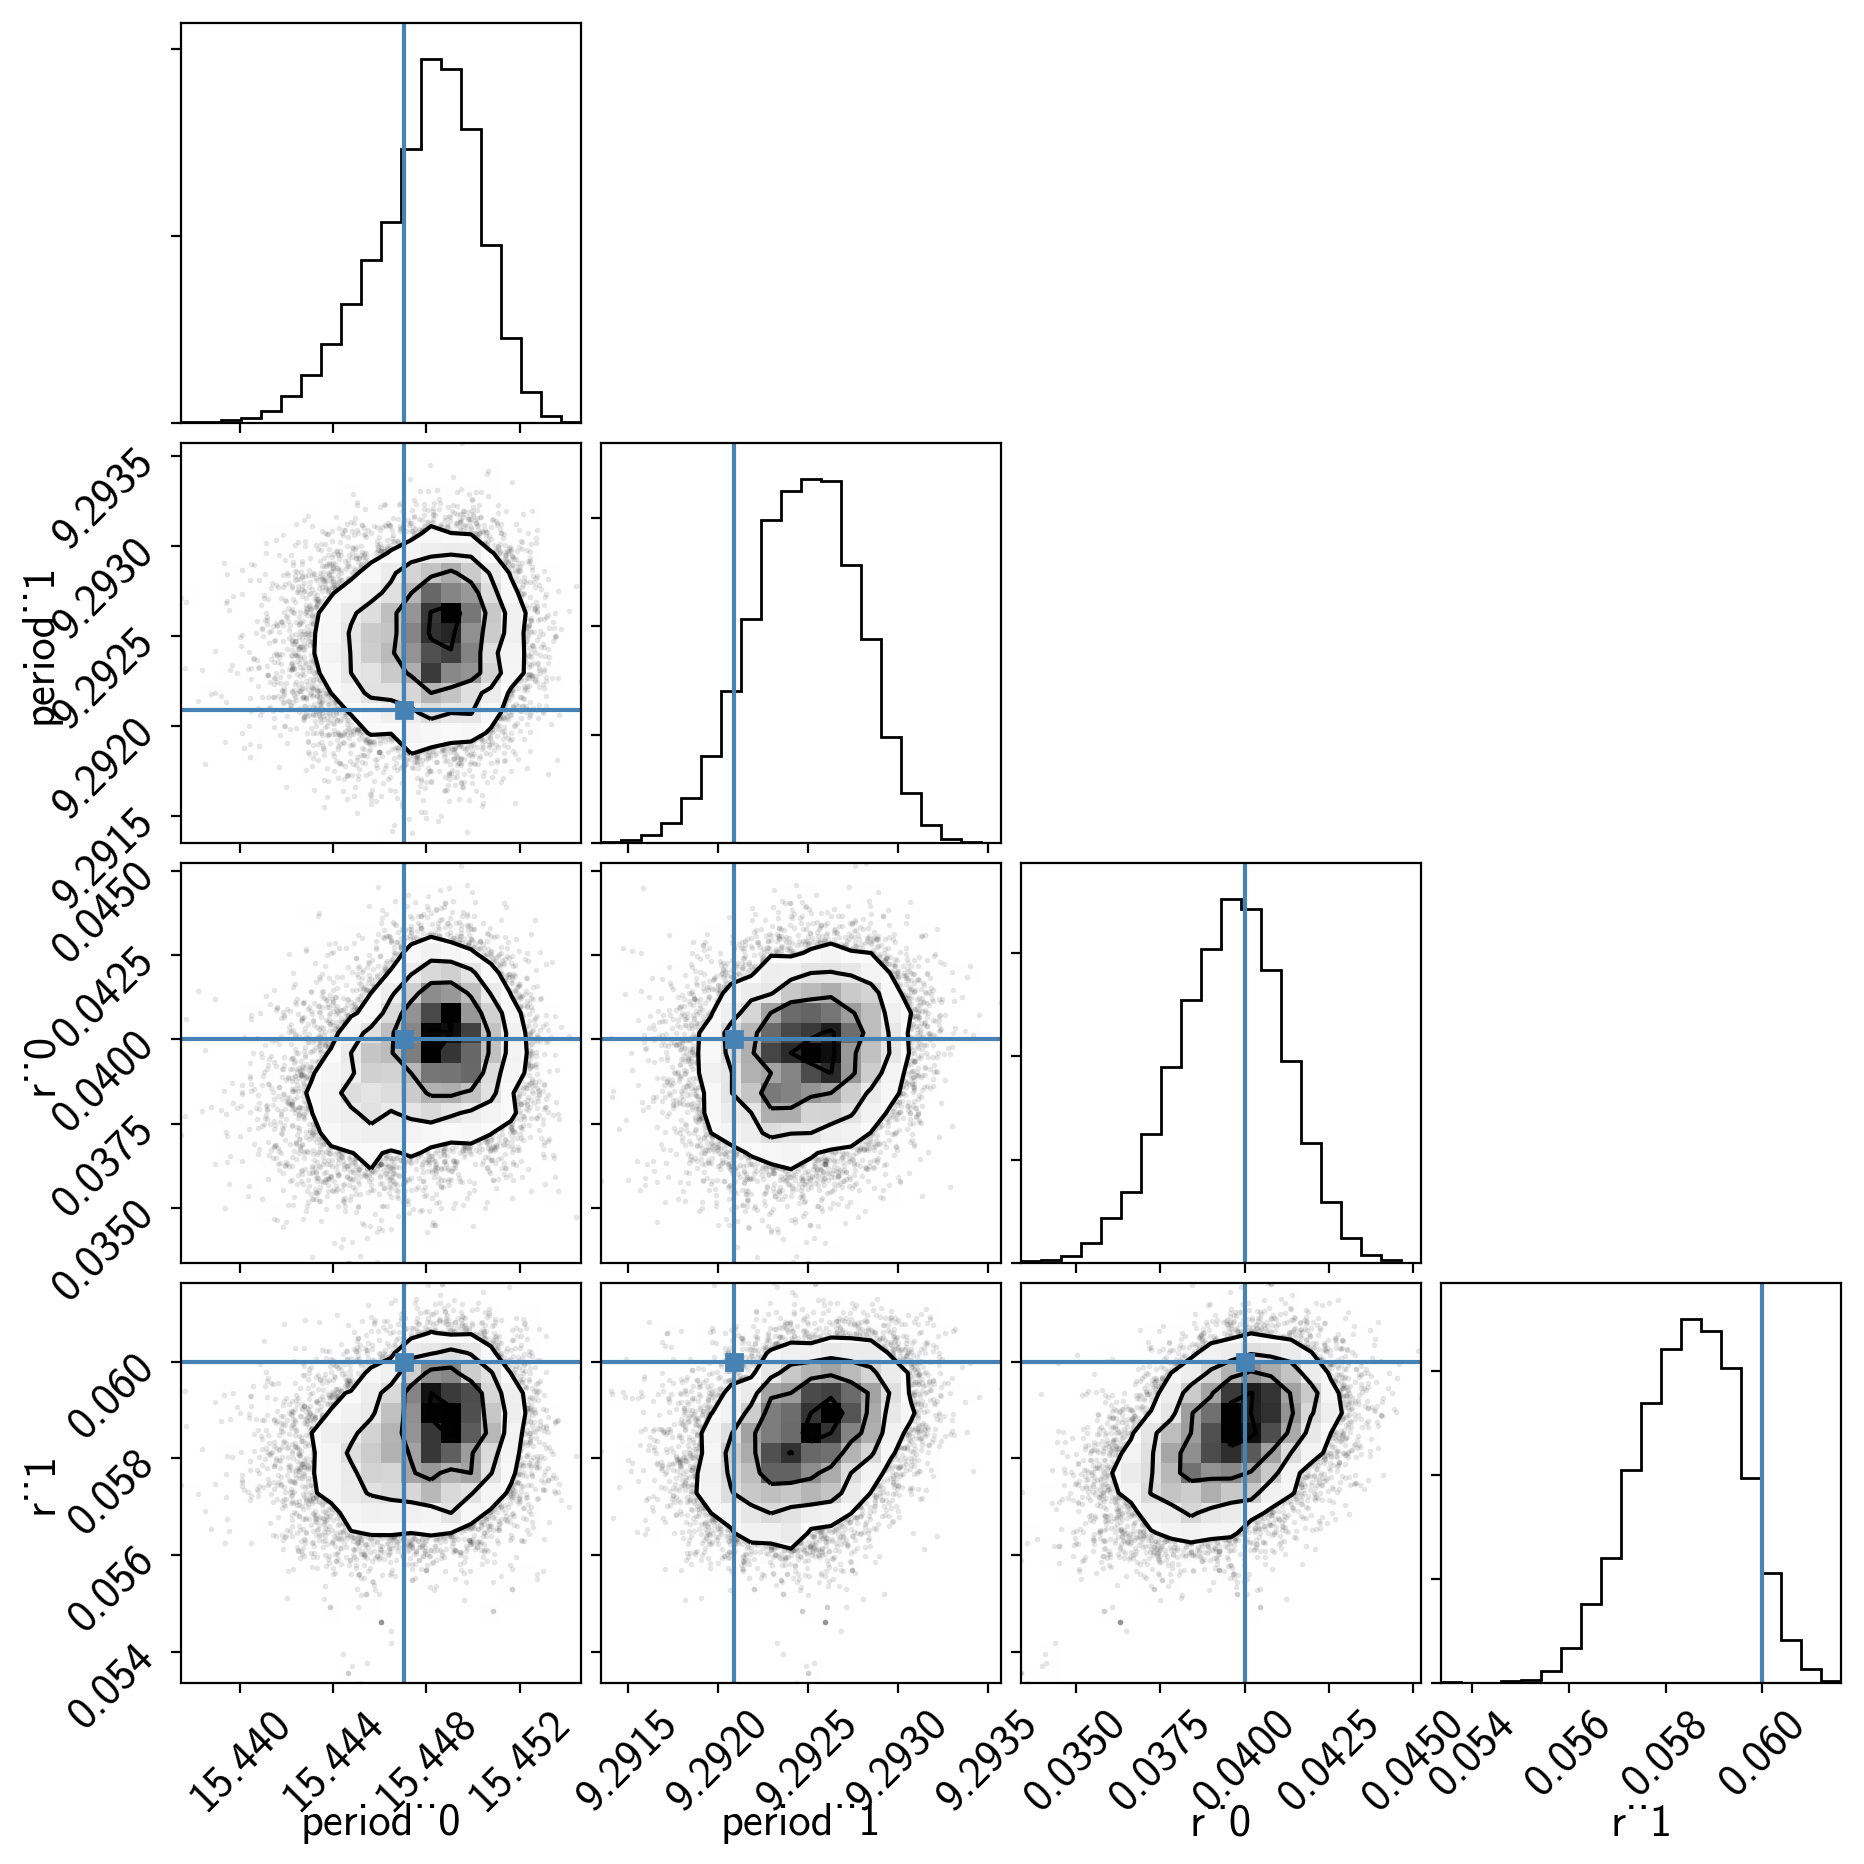

In [9]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(samples, truths=truth);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

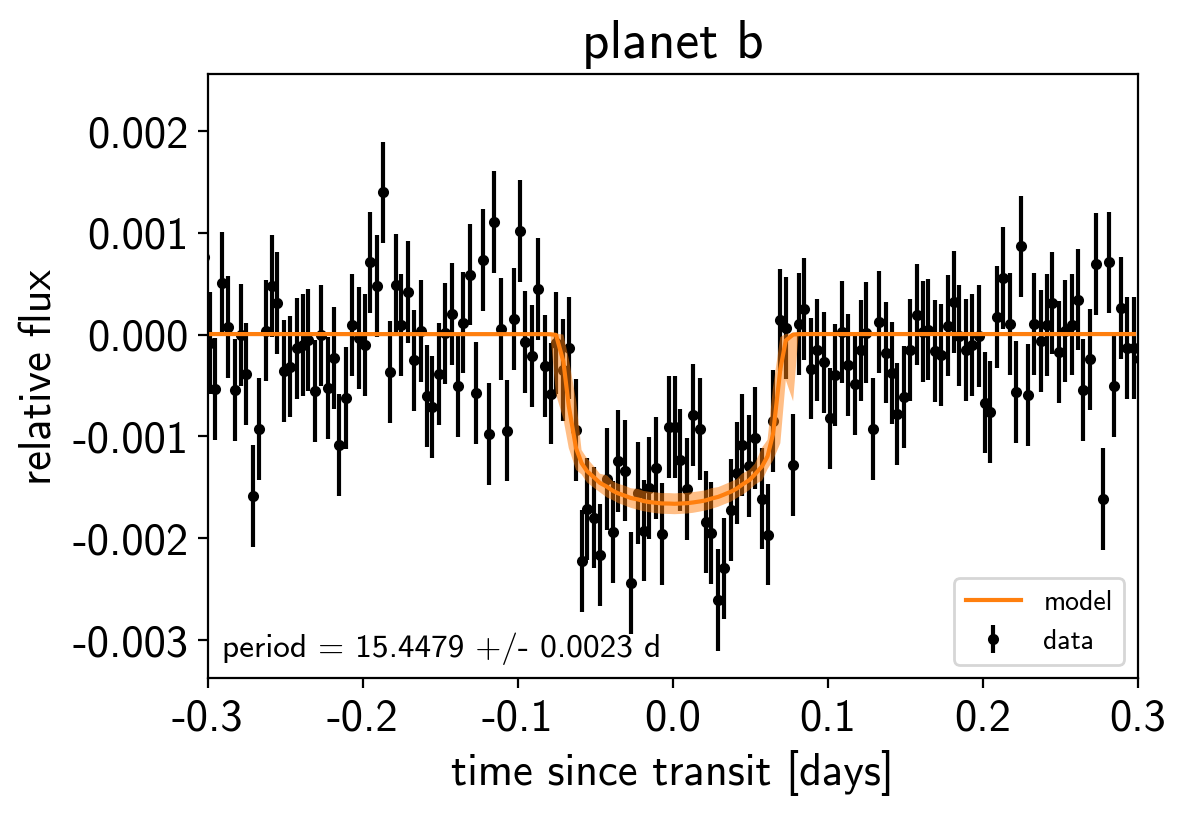

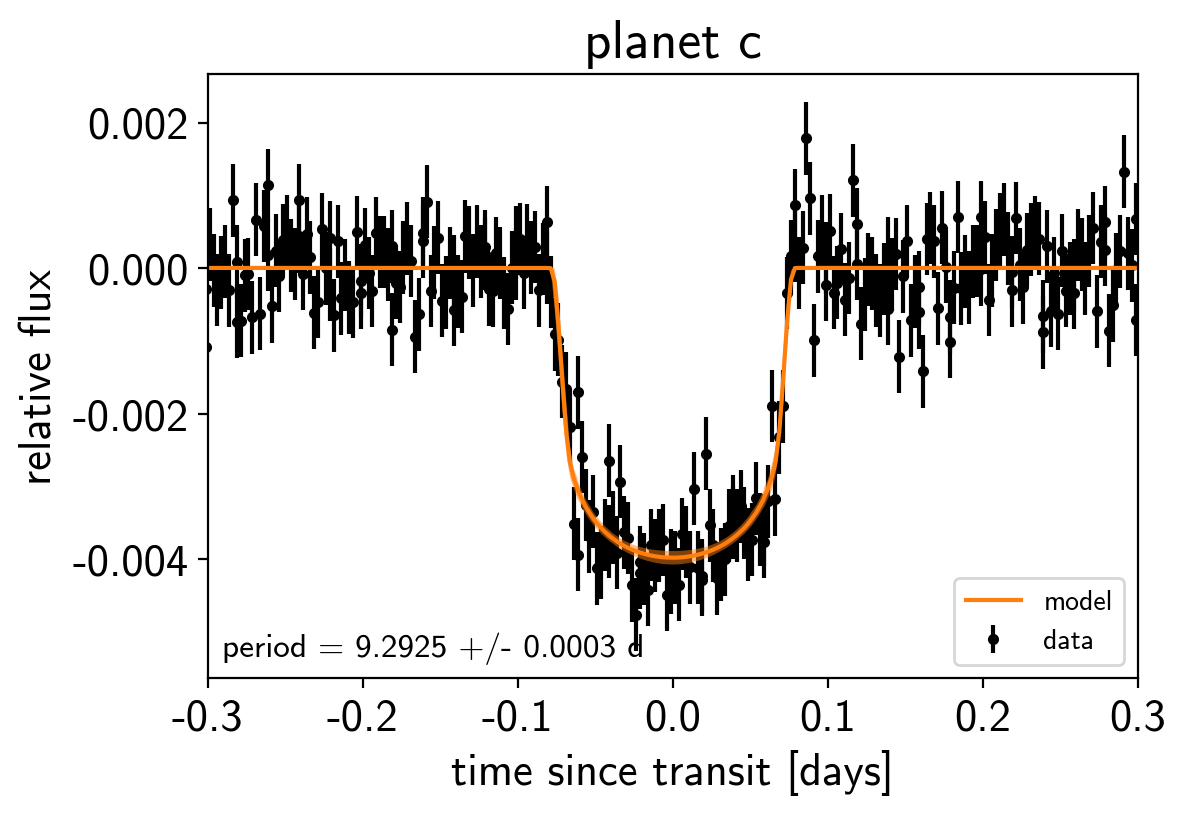

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data",
                 zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter));
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.4},
   month = feb,
    year = 2019,
     doi = {10.5281/zenodo.2561395},
     url = {https://doi.org/10.5281/zenodo.2561395}
...
